In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [5]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_14_modif_top10ventas_nov.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,14,1,AC,SVE,VENTA COMPUTARIZADA,18110090,0,2018-11-02 08:19:14,POLLO CON MENUDENCIA H-C,KG,0.0000,5.5367,63.6350,10.2350,10.2350,9.1430,FAENEADO
1,14,1,AC,SVE,VENTA COMPUTARIZADA,18110164,1,2018-11-03 07:46:01,POLLO CON MENUDENCIA H-C,KG,0.0000,9.4340,108.4910,10.2350,10.2350,15.5875,FAENEADO
2,14,1,AC,SVE,VENTA COMPUTARIZADA,18110173,0,2018-11-03 08:09:25,POLLO CON MENUDENCIA H-C,KG,0.0000,1.8005,20.7370,10.2350,10.2350,2.9797,FAENEADO
3,14,1,AC,SVE,VENTA COMPUTARIZADA,18110174,0,2018-11-03 08:17:04,POLLO CON MENUDENCIA H-C,KG,0.0000,5.4682,62.9230,10.2350,10.2350,9.0406,FAENEADO
4,14,1,AC,SVE,VENTA COMPUTARIZADA,18110175,0,2018-11-03 08:19:38,POLLO CON MENUDENCIA H-C,KG,0.0000,1.8592,21.3600,10.2350,10.2350,3.0687,FAENEADO


In [6]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [7]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [8]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-8-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [9]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] <= '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[df_todo['FechaMovimiento'] < '2023-11-01']

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [10]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (121359, 4)
sin noviembre  (119577, 4)
noviembre 2023  (1782, 4)


In [11]:
df_noviembre.head()

,NombreProducto,FechaMovimiento,MontoBase,year
106785,MUSLO,2023-11-01 08:06:19,121.6056,2023
26139,POLLO SIN MENUDENCIA H-C,2023-11-01 08:07:30,30.3045,2023
86040,PECHUGA,2023-11-01 08:15:50,11.7576,2023
106786,MUSLO,2023-11-01 08:15:50,42.9088,2023
86041,PECHUGA,2023-11-01 08:17:03,28.8880,2023


## EVALUACION

In [12]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [13]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# 10 Productos


In [14]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
# df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

# df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
# df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
# print("----Prophet----")
# print(df_noviembre_prophet.head)
# print(df_noviembre_prophet.dtypes)
# print(df_todo_hasta_nov_prophet.head)
# print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
106785                     MUSLO      2023-11-01   121.6056  2023
26139   POLLO SIN MENUDENCIA H-C      2023-11-01    30.3045  2023
86040                    PECHUGA      2023-11-01    11.7576  2023
106786                     MUSLO      2023-11-01    42.9088  2023
86041                    PECHUGA      2023-11-01    28.8880  2023
...                          ...             ...        ...   ...
86434                    PECHUGA      2023-11-30    87.2068  2023
26524   POLLO SIN MENUDENCIA H-C      2023-11-30  2582.7177  2023
41542             POLLO ESPECIAL      2023-11-30   684.8550  2023
26525   POLLO SIN MENUDENCIA H-C      2023-11-30   403.0543  2023
26526   POLLO SIN MENUDENCIA H-C      2023-11-30  1225.8415  2023

[1782 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

In [15]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_sin_2020 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year == 2020)]

print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print("todo hasta nov")
print(df_todo_hasta_nov.dtypes)

# se devuelve el tipo object a FechaMovimiento para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
#df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date

print("todo hasta nov")
print(df_todo_hasta_nov.dtypes)

print("---" *10)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print(df_todo_hasta_nov_sin_2020.shape)

         NombreProducto FechaMovimiento  MontoBase  year
86435    PECHUGA OFERTA      2018-11-01    15.5480  2018
106928  FILETE A GRANEL      2018-11-01    19.9640  2018
26566    POLLO ESPECIAL      2018-11-01    18.6900  2018
106929  FILETE A GRANEL      2018-11-01    19.9640  2018
26567    POLLO ESPECIAL      2018-11-01    19.4020  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
todo hasta nov
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
todo hasta nov
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
------------------------------
         NombreProducto FechaMovimiento  MontoBase  year
86435    PECHUGA OFERTA      2018-11-01    15.5480  2018
106928  FILETE A GRANEL      2018-11-01    19.9640  2018
2656

### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [16]:
# Obtener los 10 productos más vendidos
top_10_products = df_todo['NombreProducto'].value_counts().head(10).index

# Crear un diccionario para almacenar los DataFrames divididos
#dfs_de_productos = {}
dfs_de_productos_sin_2020 = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_10_products:
    # Crear un DataFrame para el producto actual
#    product_df = df_todo[df_todo['NombreProducto'] == product].copy()
    product_df_sin_2020 = df_todo_hasta_nov_sin_2020[df_todo_hasta_nov_sin_2020['NombreProducto'] == product].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    # product_df.set_index('FechaMovimiento', inplace=True)
    # product_df_sin_2020.set_index('FechaMovimiento', inplace=True)
#    product_df.set_index('FechaMovimiento', inplace=True)
    product_df_sin_2020.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
#    dfs_de_productos[product] = product_df
    dfs_de_productos_sin_2020[product] = product_df_sin_2020

print(top_10_products)

Index(['POLLO SIN MENUDENCIA H-C', 'PECHUGA', 'POLLO ESPECIAL',
       'FILETE A GRANEL', 'PIERNA MUSLO', 'PECHUGA OFERTA',
       'PIERNA MUSLO OFERTA', 'MUSLO', 'POLLO CON MENUDENCIA H-C',
       'ALA PRIMERA'],
      dtype='object')


In [17]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos_sin_2020.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    #product_df_sumado.set_index('FechaMovimiento', inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado


In [18]:
#print(dfs_de_productos_sin_2020)

#print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'])
print(dfs_de_productos_sin_2020['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sin_2020['POLLO SIN MENUDENCIA H-C'].head)
#print(dfs_de_productos_sumados)


NombreProducto     object
MontoBase         float64
year                int64
dtype: object
<bound method NDFrame.head of                            NombreProducto  MontoBase  year
FechaMovimiento                                           
2018-11-03       POLLO SIN MENUDENCIA H-C   209.3280  2018
2018-11-04       POLLO SIN MENUDENCIA H-C    46.9920  2018
2018-11-04       POLLO SIN MENUDENCIA H-C    22.4280  2018
2018-11-04       POLLO SIN MENUDENCIA H-C    23.1400  2018
2018-11-04       POLLO SIN MENUDENCIA H-C    45.2120  2018
...                                   ...        ...   ...
2023-10-31       POLLO SIN MENUDENCIA H-C   475.7940  2023
2023-10-31       POLLO SIN MENUDENCIA H-C    32.9211  2023
2023-10-31       POLLO SIN MENUDENCIA H-C   298.5772  2023
2023-10-31       POLLO SIN MENUDENCIA H-C    63.4392  2023
2023-10-31       POLLO SIN MENUDENCIA H-C   734.1165  2023

[14743 rows x 3 columns]>


In [19]:
# Resetear el índice sin incluirlo como columna
#product_df.reset_index(drop=True, inplace=True)

In [20]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 2023, 0, last_day_oct_2023]], columns=['NombreProducto', 'year', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['year', 'NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")

    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

Se agregó un registro de venta 0 para el producto POLLO ESPECIAL en la fecha 2023-10-31 00:00:00
Se agregó un registro de venta 0 para el producto PECHUGA OFERTA en la fecha 2023-10-31 00:00:00
Se agregó un registro de venta 0 para el producto PIERNA MUSLO OFERTA en la fecha 2023-10-31 00:00:00
Se agregó un registro de venta 0 para el producto POLLO CON MENUDENCIA H-C en la fecha 2023-10-31 00:00:00


In [21]:
print(dfs_de_productos_sumados)

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2018-11-03       POLLO SIN MENUDENCIA H-C  2018   209.3280
2018-11-04       POLLO SIN MENUDENCIA H-C  2018   456.5700
2018-11-05       POLLO SIN MENUDENCIA H-C  2018   313.8140
2018-11-06       POLLO SIN MENUDENCIA H-C  2018   704.3460
2018-11-07       POLLO SIN MENUDENCIA H-C  2018   257.6550
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023  5064.5984
2023-10-28       POLLO SIN MENUDENCIA H-C  2023   987.0990
2023-10-29       POLLO SIN MENUDENCIA H-C  2023  2787.4978
2023-10-30       POLLO SIN MENUDENCIA H-C  2023  1635.4907
2023-10-31       POLLO SIN MENUDENCIA H-C  2023  1943.9291

[1373 rows x 3 columns], 'PECHUGA':                 NombreProducto  year  MontoBase
FechaMovimiento                                
2018-11-05             PECHUGA  2018     8.7400
2018-11-06             

In [22]:
# unique_products = df_todo['NombreProducto'].unique()
# print(unique_products)

In [23]:
import copy

# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_prophet = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

    # Eliminar la columna 'year'
    product_df_prophet.drop(columns=['year'], inplace=True)

In [24]:
print(dfs_de_productos_sumados['POLLO CON MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO CON MENUDENCIA H-C'].head)

NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2018-11-02       POLLO CON MENUDENCIA H-C  2018    63.6350
2018-11-03       POLLO CON MENUDENCIA H-C  2018   718.8530
2018-11-04       POLLO CON MENUDENCIA H-C  2018   245.5510
2018-11-08       POLLO CON MENUDENCIA H-C  2018   312.5680
2018-11-10       POLLO CON MENUDENCIA H-C  2018   283.5540
...                                   ...   ...        ...
2023-10-11       POLLO CON MENUDENCIA H-C  2023   225.7930
2023-10-21       POLLO CON MENUDENCIA H-C  2023   270.1951
2023-10-26       POLLO CON MENUDENCIA H-C  2023   445.5429
2023-10-27       POLLO CON MENUDENCIA H-C  2023  1589.3531
2023-10-31       POLLO CON MENUDENCIA H-C  2023     0.0000

[820 rows x 3 columns]>


In [25]:
print(dfs_de_productos_sumados_prophet['POLLO CON MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO CON MENUDENCIA H-C'].head)

ds                datetime64[ns]
NombreProducto            object
y                        float64
dtype: object
<bound method NDFrame.head of             ds            NombreProducto         y
0   2018-11-02  POLLO CON MENUDENCIA H-C   63.6350
1   2018-11-03  POLLO CON MENUDENCIA H-C  718.8530
2   2018-11-04  POLLO CON MENUDENCIA H-C  245.5510
3   2018-11-08  POLLO CON MENUDENCIA H-C  312.5680
4   2018-11-10  POLLO CON MENUDENCIA H-C  283.5540
..         ...                       ...       ...
815 2023-10-11  POLLO CON MENUDENCIA H-C  225.7930
816 2023-10-21  POLLO CON MENUDENCIA H-C  270.1951
817 2023-10-26  POLLO CON MENUDENCIA H-C  445.5429
818 2023-10-27  POLLO CON MENUDENCIA H-C 1589.3531
819 2023-10-31  POLLO CON MENUDENCIA H-C    0.0000

[820 rows x 3 columns]>


In [26]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

             ds            NombreProducto         y
0    2018-11-03  POLLO SIN MENUDENCIA H-C  209.3280
1    2018-11-04  POLLO SIN MENUDENCIA H-C  456.5700
2    2018-11-05  POLLO SIN MENUDENCIA H-C  313.8140
3    2018-11-06  POLLO SIN MENUDENCIA H-C  704.3460
4    2018-11-07  POLLO SIN MENUDENCIA H-C  257.6550
...         ...                       ...       ...
1368 2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
1369 2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
1370 2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
1371 2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
1372 2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[1373 rows x 3 columns]
             ds NombreProducto        y
0    2018-11-05        PECHUGA   8.7400
1    2018-11-06        PECHUGA 171.3040
2    2018-11-09        PECHUGA 492.4760
3    2018-11-10        PECHUGA  52.6240
4    2018-11-12        PECHUGA 317.0320
...         ...            ...      ...
1161 2023-10-27        PECHUGA 227.4516
1162 2023-10-28        PECHUGA 

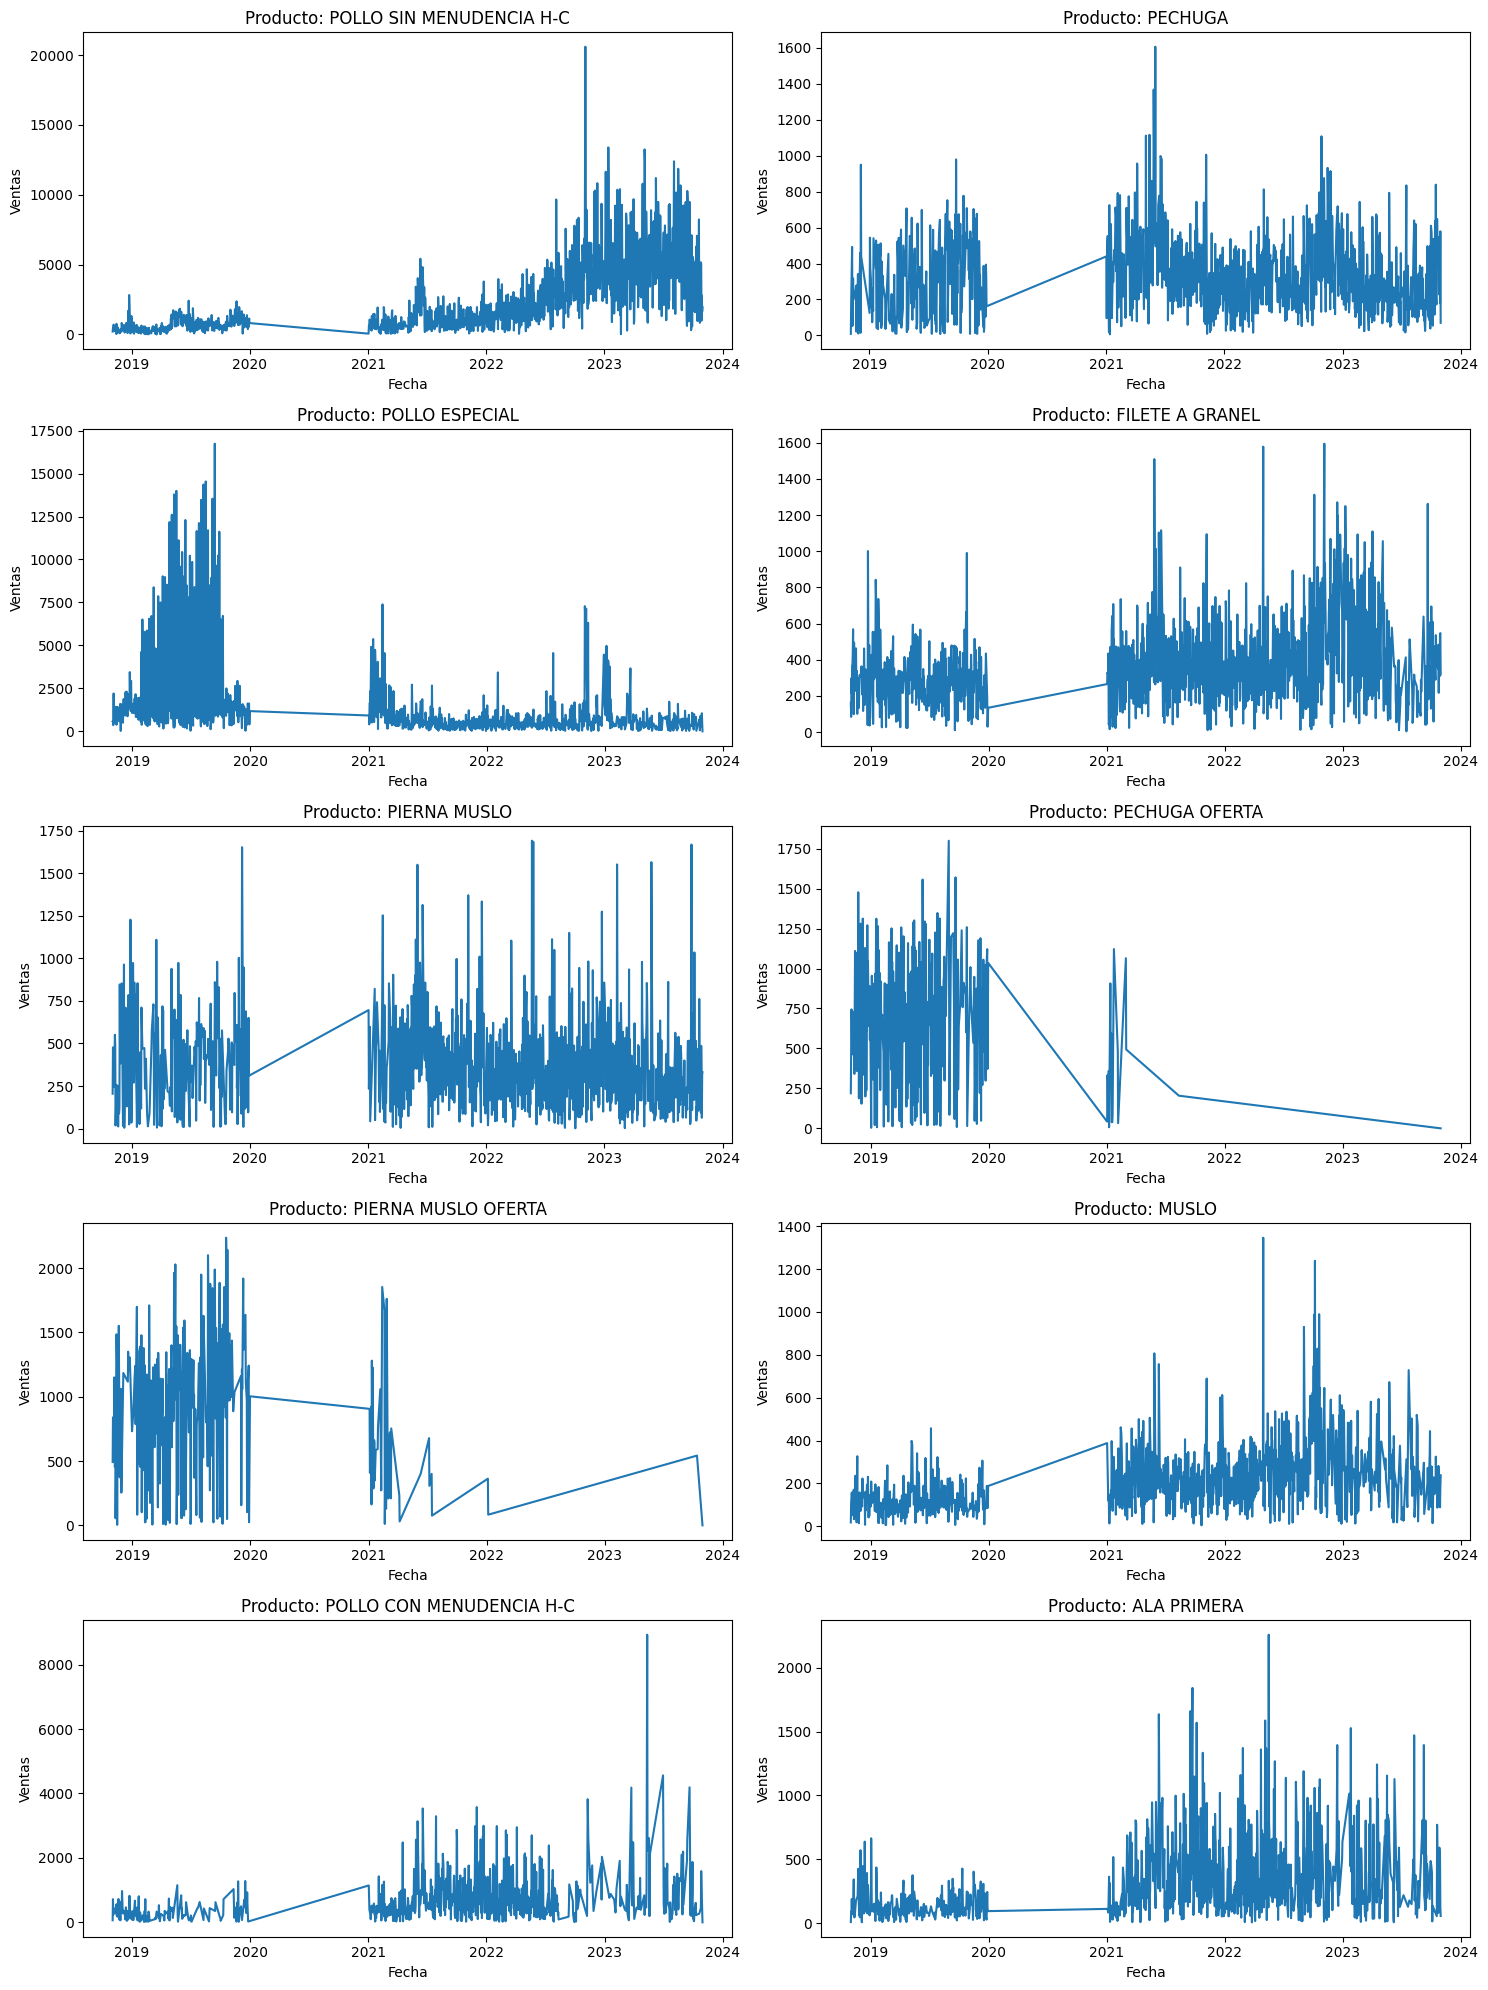

In [27]:
# Crear una figura y ejes para los gráficos
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Cambia el tamaño según sea necesario

# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Calcular las coordenadas de los subgráficos
    row, col = divmod(i, 2)

    # Crear un gráfico de líneas para cada producto
    axs[row, col].plot(product_df['ds'], product_df['y'], label=product)
    axs[row, col].set_title(f'Producto: {product}')
    axs[row, col].set_xlabel('Fecha')
    axs[row, col].set_ylabel('Ventas')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

In [28]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 4 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 5 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 6 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 7 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 8 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 9 - Tipos de D

### clonar para LSTM y ARIMA


In [29]:
dfs_de_productos_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
 FechaMovimiento                                           
 2018-11-03       POLLO SIN MENUDENCIA H-C  2018   209.3280
 2018-11-04       POLLO SIN MENUDENCIA H-C  2018   456.5700
 2018-11-05       POLLO SIN MENUDENCIA H-C  2018   313.8140
 2018-11-06       POLLO SIN MENUDENCIA H-C  2018   704.3460
 2018-11-07       POLLO SIN MENUDENCIA H-C  2018   257.6550
 ...                                   ...   ...        ...
 2023-10-27       POLLO SIN MENUDENCIA H-C  2023  5064.5984
 2023-10-28       POLLO SIN MENUDENCIA H-C  2023   987.0990
 2023-10-29       POLLO SIN MENUDENCIA H-C  2023  2787.4978
 2023-10-30       POLLO SIN MENUDENCIA H-C  2023  1635.4907
 2023-10-31       POLLO SIN MENUDENCIA H-C  2023  1943.9291
 
 [1373 rows x 3 columns],
 'PECHUGA':                 NombreProducto  year  MontoBase
 FechaMovimiento                                
 2018-11-05             PECHUGA  2018     8.7400
 2018-

In [30]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_lstm = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    product_df_lstm.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)

    # Preprocesamiento de fechas utilizando el índice
    product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    product_df_lstm['Month'] = product_df_lstm.index.month
    product_df_lstm['Year'] = product_df_lstm.index.year

    product_df_lstm.drop(columns=['year'], inplace=True)

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

# Ahora, el índice es 'FechaMovimiento' nuevamente, puedes acceder a la columna
# 'FechaMovimiento' si es necesario después del bucle.

# Ejemplo de acceso después del bucle
# product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])
#    product_df_lstm.reset_index(inplace=True)

In [31]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_arima = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
     # Restablecer el índice
    product_df_arima.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)
    # Eliminar la columna 'year'
    product_df_arima.drop(columns=['year'], inplace=True)

In [32]:
print(dfs_de_productos_sumados_arima['PECHUGA'])

                NombreProducto  MontoBase
FechaMovimiento                          
2018-11-05             PECHUGA     8.7400
2018-11-06             PECHUGA   171.3040
2018-11-09             PECHUGA   492.4760
2018-11-10             PECHUGA    52.6240
2018-11-12             PECHUGA   317.0320
...                        ...        ...
2023-10-27             PECHUGA   227.4516
2023-10-28             PECHUGA   509.0360
2023-10-29             PECHUGA   179.5288
2023-10-30             PECHUGA   579.2872
2023-10-31             PECHUGA    69.9200

[1166 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [33]:
# Obtener los 10 productos más vendidos
top_10_products = df_todo['NombreProducto'].value_counts().head(10).index

# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_10_products:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [34]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    product_df_sumado.drop(columns=['year'], inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.1556
2023-11-17       POLLO SIN MENUDENCIA H-C  115

In [35]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Se agregaron 0 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto PECHUGA son: DatetimeIndex(['2023-11-28'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PECHUGA en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto PECHUGA en noviembre.
Las fechas que no están en el producto POLLO ESPECIAL son: DatetimeIndex(['2023-11-11', '2023-11-12', '2023-11-22', '2023-11-23',
               '2023-11-24', '2023-11-26'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO ESPECIAL en las fechas faltantes.
Se agregaron 6 registros de venta 0 para el producto POLLO ESPECIAL en noviembre.
Las fechas que no están en el producto FILETE A GRANEL son: DatetimeIndex(['2023-11-06', '2023-11-14', '2023-11-15'

In [36]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Convertir el índice a objetos datetime y luego quitar la información de tiempo
#     product_df.index = pd.to_datetime(product_df.index).date

#     # Imprimir información sobre el producto
#     print(f"DataFrame actualizado para el producto {product}:\n{product_df}")
# print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].head(5))

In [37]:
print(dfs_noviembre_sumados)
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])
#print(dfs_noviembre_sumados['PIERNA MUSLO OFERTA'])

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.1556
2023-11-17       

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones sin el 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/5n069e71.json


             ds            NombreProducto         y
0    2018-11-03  POLLO SIN MENUDENCIA H-C  209.3280
1    2018-11-04  POLLO SIN MENUDENCIA H-C  456.5700
2    2018-11-05  POLLO SIN MENUDENCIA H-C  313.8140
3    2018-11-06  POLLO SIN MENUDENCIA H-C  704.3460
4    2018-11-07  POLLO SIN MENUDENCIA H-C  257.6550
...         ...                       ...       ...
1368 2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
1369 2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
1370 2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
1371 2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
1372 2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[1373 rows x 3 columns]


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/1nyafa7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47914', 'data', 'file=/tmp/tmp6jo4yu6f/5n069e71.json', 'init=/tmp/tmp6jo4yu6f/1nyafa7i.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modelydhtiu59/prophet_model-20240222235755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


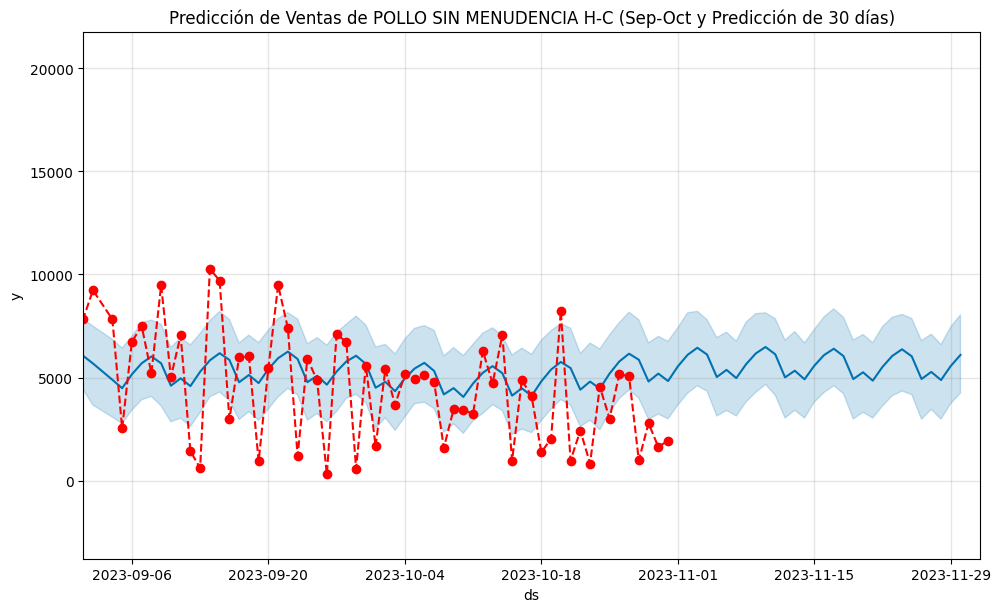

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/sdw45ebq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/auhec00d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88253', 'data', 'file=/tmp/tmp6jo4yu6f/sdw45ebq.json', 'init=/tmp/tmp6jo4yu6f/auhec00d.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modely3nqmulq/prophet_model-20240222235756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
1373 2023-11-01 5539.9402
1374 2023-11-02 6099.6238
1375 2023-11-03 6446.3170
1376 2023-11-04 6118.8165
1377 2023-11-05 5027.7751
1378 2023-11-06 5373.5370
1379 2023-11-07 4974.6598
1380 2023-11-08 5645.9059
1381 2023-11-09 6170.4979
1382 2023-11-10 6484.4363
1383 2023-11-11 6127.1791
1384 2023-11-12 5009.9285
1385 2023-11-13 5333.4548
1386 2023-11-14 4916.6117
1387 2023-11-15 5574.3231
1388 2023-11-16 6089.8400
1389 2023-11-17 6399.0621
1390 2023-11-18 6041.2254
1391 2023-11-19 4927.2007
1392 2023-11-20 5257.3319
1393 2023-11-21 4849.9678
1394 2023-11-22 5519.4681
1395 2023-11-23 6048.4801
1396 2023-11-24 6372.2812
1397 2023-11-25 6029.4867
1398 2023-11-26 4930.3691
1399 2023-11-27 5274.7142
1400 2023-11-28 4880.3703
1401 2023-11-29 5561.2689
1402 2023-11-30 6099.7127
             ds NombreProducto        y
0    2018-11-05        PECHUGA   8.7400
1    2018-11-06        PECHUGA 171.3040
2    2018-

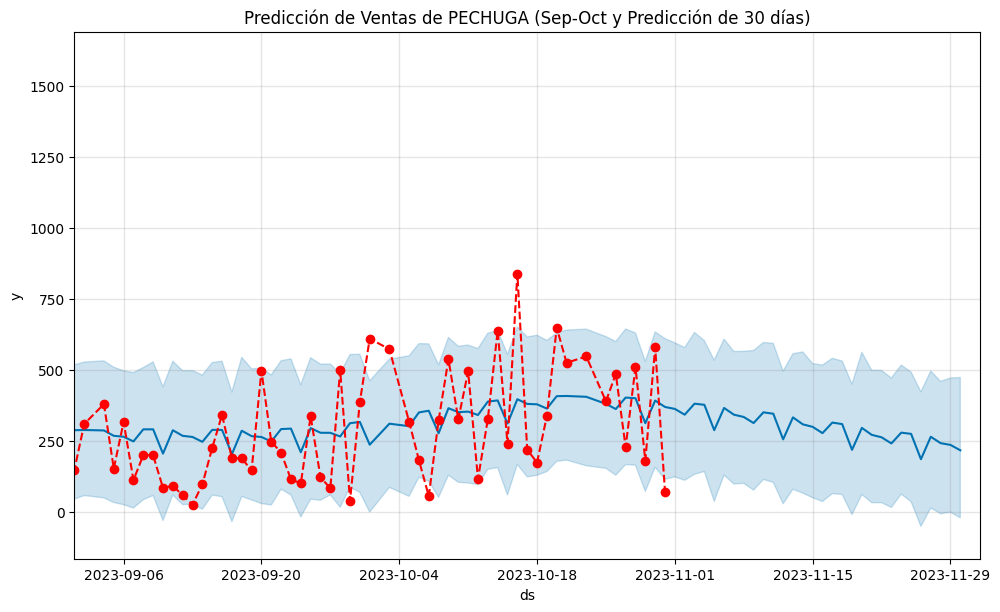

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/lcwjt1oe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/p97zim2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25493', 'data', 'file=/tmp/tmp6jo4yu6f/lcwjt1oe.json', 'init=/tmp/tmp6jo4yu6f/p97zim2v.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modelz5_vkr4q/prophet_model-20240222235756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para PECHUGA:
             ds     yhat
1166 2023-11-01 362.1221
1167 2023-11-02 341.7930
1168 2023-11-03 380.5524
1169 2023-11-04 376.6171
1170 2023-11-05 287.1660
1171 2023-11-06 365.5479
1172 2023-11-07 341.7973
1173 2023-11-08 333.6980
1174 2023-11-09 312.2989
1175 2023-11-10 350.0493
1176 2023-11-11 345.1558
1177 2023-11-12 254.7918
1178 2023-11-13 332.3053
1179 2023-11-14 307.7352
1180 2023-11-15 298.8750
1181 2023-11-16 276.7882
1182 2023-11-17 313.9430
1183 2023-11-18 308.5693
1184 2023-11-19 217.8664
1185 2023-11-20 295.2106
1186 2023-11-21 270.6699
1187 2023-11-22 262.0663
1188 2023-11-23 240.4908
1189 2023-11-24 278.4359
1190 2023-11-25 274.1515
1191 2023-11-26 184.8517
1192 2023-11-27 263.9212
1193 2023-11-28 241.4290
1194 2023-11-29 235.1903
1195 2023-11-30 216.2803
             ds  NombreProducto         y
0    2018-11-01  POLLO ESPECIAL  576.7200
1    2018-11-02  POLLO ESPECIAL  601.3730
2    2018-11-03  POLLO ESPECIAL  358.6700
3    2018-

23:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


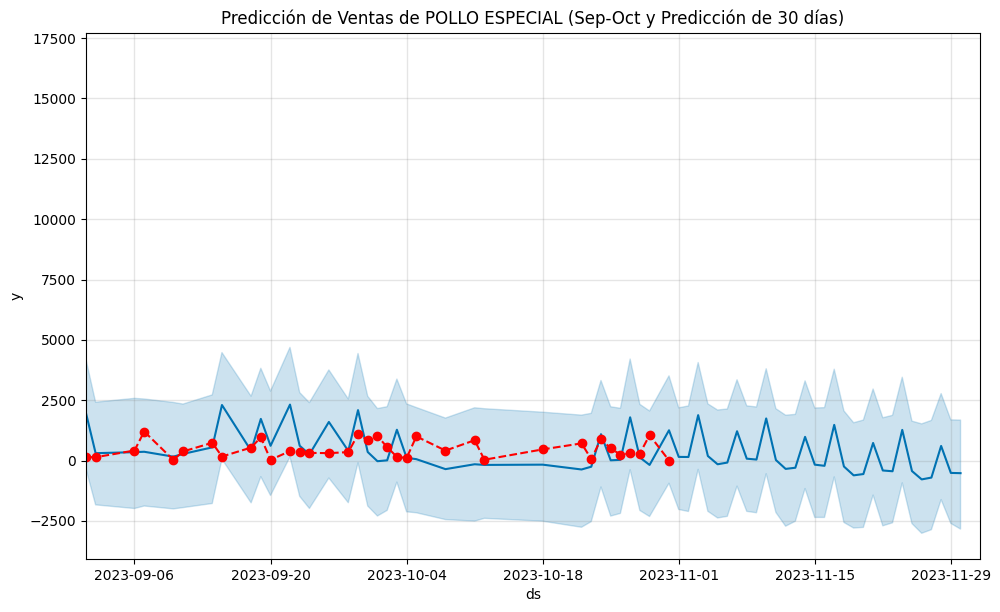

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/ec1p8es2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/0z_oqngu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47845', 'data', 'file=/tmp/tmp6jo4yu6f/ec1p8es2.json', 'init=/tmp/tmp6jo4yu6f/0z_oqngu.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modelniwumi8e/prophet_model-20240222235757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para POLLO ESPECIAL:
             ds      yhat
1249 2023-11-01  149.9981
1250 2023-11-02  146.0614
1251 2023-11-03 1880.2938
1252 2023-11-04  186.4367
1253 2023-11-05 -155.4516
1254 2023-11-06  -84.5489
1255 2023-11-07 1213.2262
1256 2023-11-08   76.6632
1257 2023-11-09   40.1204
1258 2023-11-10 1743.3829
1259 2023-11-11   20.8079
1260 2023-11-12 -347.0000
1261 2023-11-13 -298.7518
1262 2023-11-14  980.0116
1263 2023-11-15 -171.6378
1264 2023-11-16 -219.1580
1265 2023-11-17 1477.3200
1266 2023-11-18 -247.8609
1267 2023-11-19 -614.2041
1268 2023-11-20 -560.6162
1269 2023-11-21  727.0881
1270 2023-11-22 -412.3613
1271 2023-11-23 -444.8202
1272 2023-11-24 1269.1398
1273 2023-11-25 -436.6078
1274 2023-11-26 -782.0506
1275 2023-11-27 -706.5795
1276 2023-11-28  603.5188
1277 2023-11-29 -513.4715
1278 2023-11-30 -523.8153
             ds   NombreProducto        y
0    2018-11-01  FILETE A GRANEL 161.5520
1    2018-11-02  FILETE A GRANEL  84.0880
2    2018-11-0

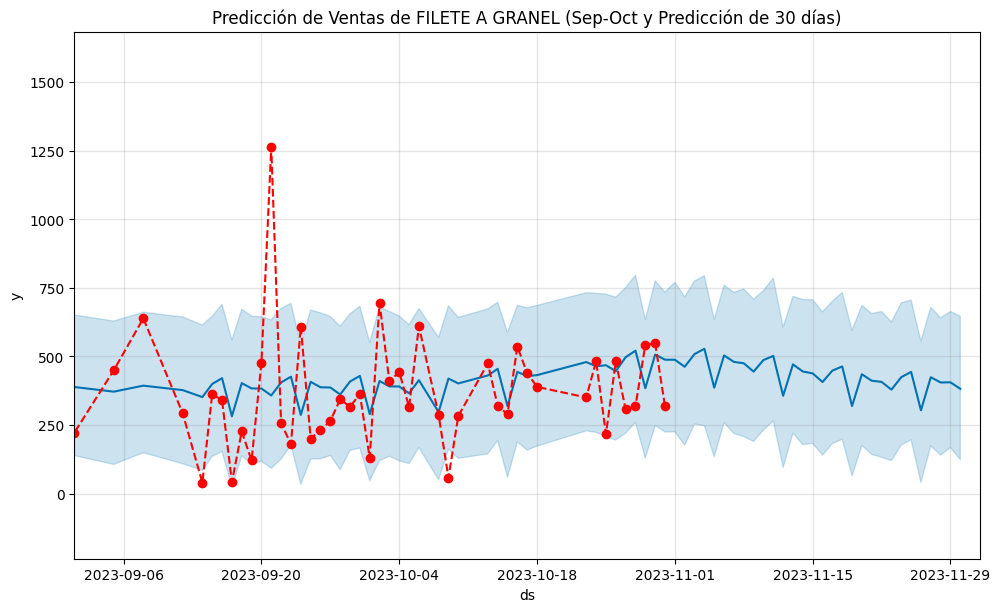

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/s42wyvrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/a2r02cjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53766', 'data', 'file=/tmp/tmp6jo4yu6f/s42wyvrn.json', 'init=/tmp/tmp6jo4yu6f/a2r02cjl.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modelkn50gyvs/prophet_model-20240222235758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para FILETE A GRANEL:
             ds     yhat
1260 2023-11-01 488.0622
1261 2023-11-02 462.4260
1262 2023-11-03 508.7704
1263 2023-11-04 527.8872
1264 2023-11-05 386.2625
1265 2023-11-06 503.6560
1266 2023-11-07 480.2378
1267 2023-11-08 475.2248
1268 2023-11-09 444.9304
1269 2023-11-10 486.8961
1270 2023-11-11 501.9995
1271 2023-11-12 356.8062
1272 2023-11-13 471.1470
1273 2023-11-14 445.2531
1274 2023-11-15 438.3913
1275 2023-11-16 406.9117
1276 2023-11-17 448.3785
1277 2023-11-18 463.6778
1278 2023-11-19 319.3686
1279 2023-11-20 435.2605
1280 2023-11-21 411.5490
1281 2023-11-22 407.4514
1282 2023-11-23 379.2560
1283 2023-11-24 424.4541
1284 2023-11-25 443.8494
1285 2023-11-26 303.9111
1286 2023-11-27 424.3535
1287 2023-11-28 405.2741
1288 2023-11-29 405.7912
1289 2023-11-30 382.0959
             ds NombreProducto        y
0    2018-11-03   PIERNA MUSLO 204.8840
1    2018-11-04   PIERNA MUSLO 477.0200
2    2018-11-08   PIERNA MUSLO 245.0880
3    2018-

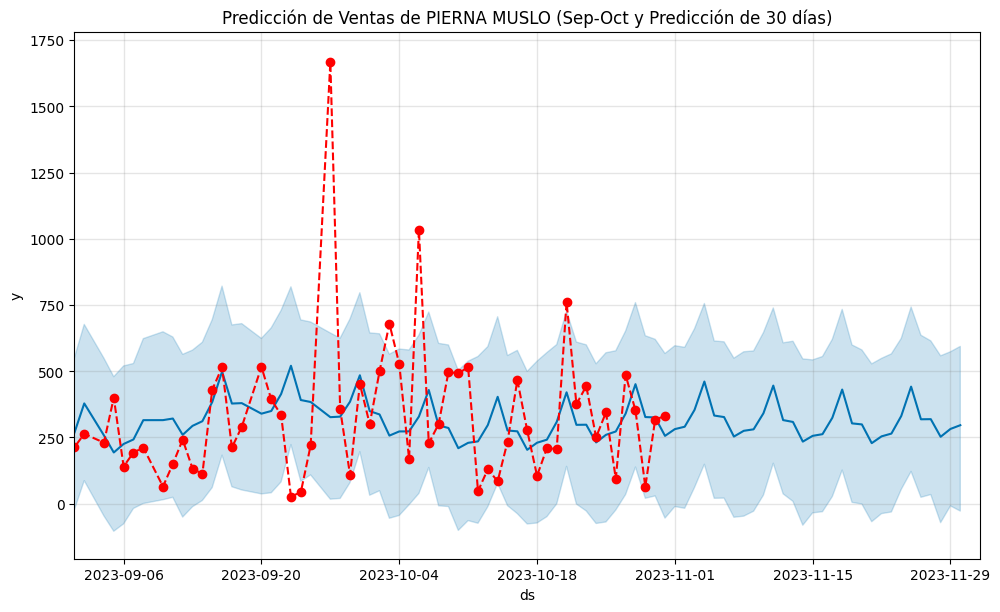

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/al9__6k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/z12bxmz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39563', 'data', 'file=/tmp/tmp6jo4yu6f/al9__6k1.json', 'init=/tmp/tmp6jo4yu6f/z12bxmz3.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modella5dgua2/prophet_model-20240222235759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para PIERNA MUSLO:
             ds     yhat
1152 2023-11-01 281.2274
1153 2023-11-02 290.2730
1154 2023-11-03 353.8949
1155 2023-11-04 460.8154
1156 2023-11-05 332.4681
1157 2023-11-06 326.7415
1158 2023-11-07 253.1308
1159 2023-11-08 274.8480
1160 2023-11-09 280.4565
1161 2023-11-10 341.0844
1162 2023-11-11 445.5298
1163 2023-11-12 315.2871
1164 2023-11-13 308.2907
1165 2023-11-14 234.0659
1166 2023-11-15 255.8381
1167 2023-11-16 262.1681
1168 2023-11-17 324.1660
1169 2023-11-18 430.5969
1170 2023-11-19 302.9088
1171 2023-11-20 298.9775
1172 2023-11-21 228.2594
1173 2023-11-22 253.9025
1174 2023-11-23 264.3837
1175 2023-11-24 330.7246
1176 2023-11-25 441.5994
1177 2023-11-26 318.3652
1178 2023-11-27 318.8085
1179 2023-11-28 252.2996
1180 2023-11-29 281.9058
1181 2023-11-30 296.0300
            ds  NombreProducto         y
0   2018-11-01  PECHUGA OFERTA  219.6040
1   2018-11-02  PECHUGA OFERTA  495.7880
2   2018-11-03  PECHUGA OFERTA  744.1880
3   2018-

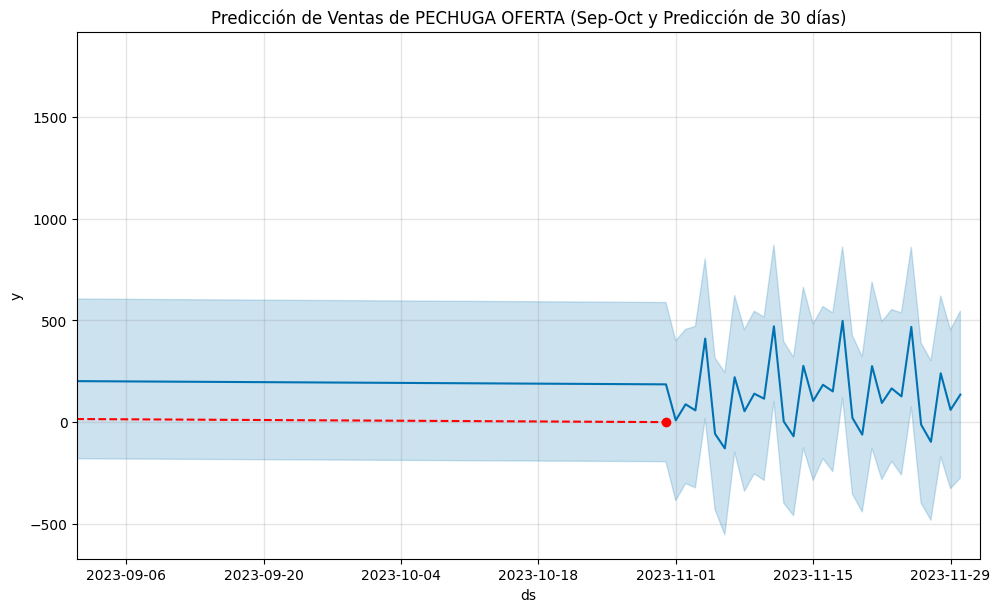

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/ztnf4cct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/j4e0wid2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57483', 'data', 'file=/tmp/tmp6jo4yu6f/ztnf4cct.json', 'init=/tmp/tmp6jo4yu6f/j4e0wid2.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modelp8il4th6/prophet_model-20240222235759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para PECHUGA OFERTA:
            ds      yhat
330 2023-11-01    8.7978
331 2023-11-02   87.6093
332 2023-11-03   57.7493
333 2023-11-04  410.5167
334 2023-11-05  -57.4964
335 2023-11-06 -129.0495
336 2023-11-07  220.6892
337 2023-11-08   53.4808
338 2023-11-09  139.7641
339 2023-11-10  115.1221
340 2023-11-11  470.8093
341 2023-11-12    3.4460
342 2023-11-13  -69.6293
343 2023-11-14  276.5781
344 2023-11-15  104.0511
345 2023-11-16  183.5009
346 2023-11-17  150.8236
347 2023-11-18  497.6171
348 2023-11-19   20.8638
349 2023-11-20  -61.7291
350 2023-11-21  275.1966
351 2023-11-22   93.9702
352 2023-11-23  165.6213
353 2023-11-24  126.3262
354 2023-11-25  467.9164
355 2023-11-26  -12.4464
356 2023-11-27  -96.9351
357 2023-11-28  239.8654
358 2023-11-29   60.2771
359 2023-11-30  135.2579
            ds       NombreProducto         y
0   2018-11-01  PIERNA MUSLO OFERTA  492.3840
1   2018-11-02  PIERNA MUSLO OFERTA  839.5920
2   2018-11-05  PIERNA MUSLO OFER

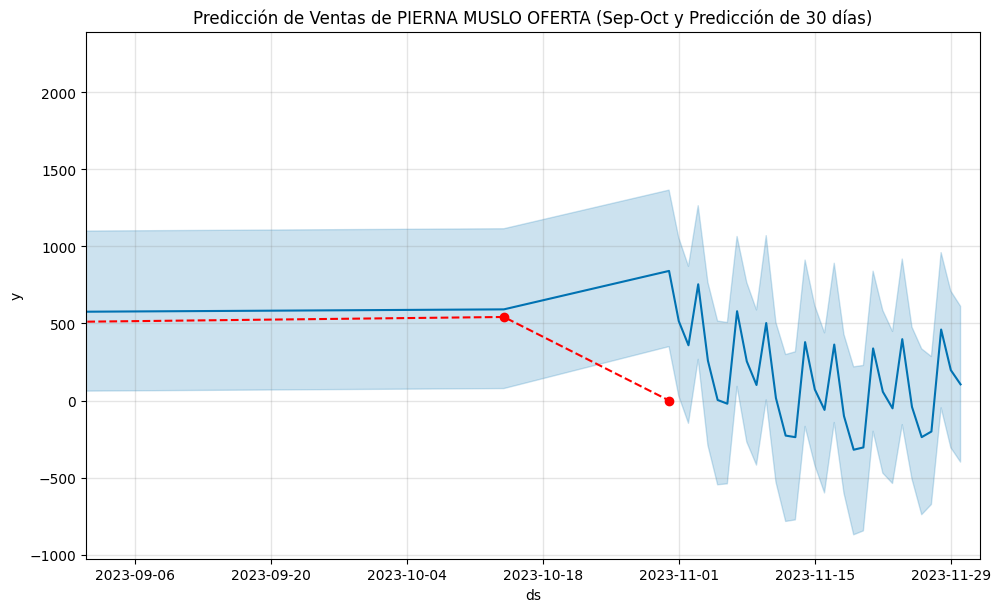

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/ojgxi1cx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/906u6sru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82169', 'data', 'file=/tmp/tmp6jo4yu6f/ojgxi1cx.json', 'init=/tmp/tmp6jo4yu6f/906u6sru.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_model7710_7w0/prophet_model-20240222235800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:58:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para PIERNA MUSLO OFERTA:
            ds      yhat
310 2023-11-01  515.4120
311 2023-11-02  358.5974
312 2023-11-03  754.4468
313 2023-11-04  258.4912
314 2023-11-05    3.4740
315 2023-11-06  -20.7861
316 2023-11-07  579.5964
317 2023-11-08  254.2374
318 2023-11-09  100.7386
319 2023-11-10  502.7456
320 2023-11-11   15.7153
321 2023-11-12 -227.7196
322 2023-11-13 -237.8856
323 2023-11-14  378.9244
324 2023-11-15   72.1177
325 2023-11-16  -60.9407
326 2023-11-17  363.1338
327 2023-11-18 -100.4841
328 2023-11-19 -319.4613
329 2023-11-20 -304.4377
330 2023-11-21  337.9715
331 2023-11-22   56.8456
332 2023-11-23  -50.7785
333 2023-11-24  398.1591
334 2023-11-25  -41.4836
335 2023-11-26 -237.6774
336 2023-11-27 -201.3496
337 2023-11-28  460.6180
338 2023-11-29  197.0626
339 2023-11-30  104.8074
             ds NombreProducto        y
0    2018-11-01          MUSLO  17.4800
1    2018-11-02          MUSLO 110.4000
2    2018-11-04          MUSLO 157.2280
3    2

23:58:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


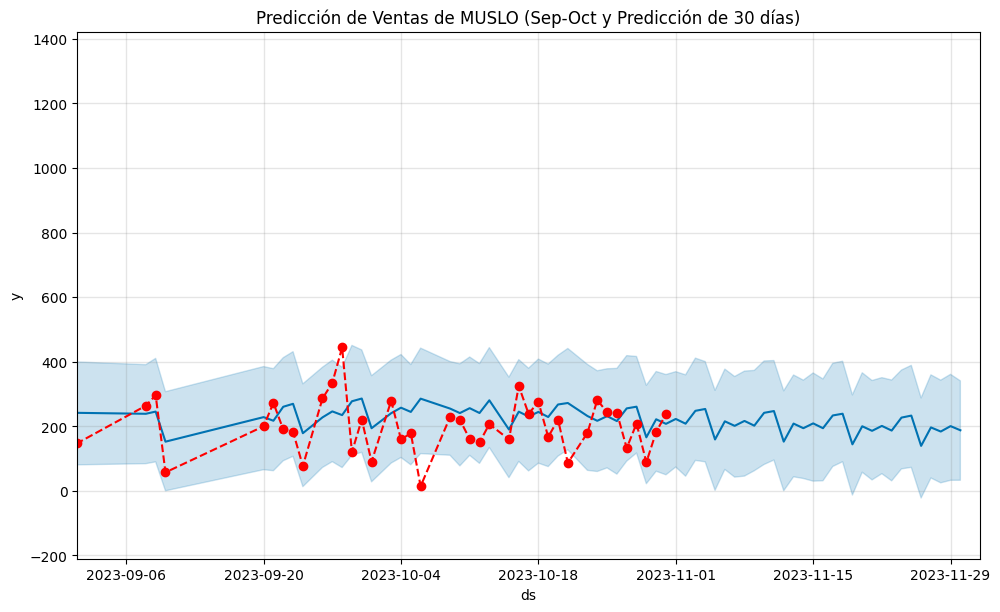

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/dez24vgi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/f71f0g65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83898', 'data', 'file=/tmp/tmp6jo4yu6f/dez24vgi.json', 'init=/tmp/tmp6jo4yu6f/f71f0g65.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_model4cfqjw2l/prophet_model-20240222235801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:58:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:58:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para MUSLO:
             ds     yhat
1129 2023-11-01 222.5573
1130 2023-11-02 207.9024
1131 2023-11-03 247.7614
1132 2023-11-04 253.4855
1133 2023-11-05 159.0305
1134 2023-11-06 215.2048
1135 2023-11-07 201.2233
1136 2023-11-08 216.4573
1137 2023-11-09 201.7844
1138 2023-11-10 241.5342
1139 2023-11-11 247.0703
1140 2023-11-12 152.3641
1141 2023-11-13 208.2427
1142 2023-11-14 193.9427
1143 2023-11-15 208.8581
1144 2023-11-16 193.8910
1145 2023-11-17 233.3958
1146 2023-11-18 238.7604
1147 2023-11-19 143.9797
1148 2023-11-20 199.9025
1149 2023-11-21 185.7844
1150 2023-11-22 201.0357
1151 2023-11-23 186.5708
1152 2023-11-24 226.7523
1153 2023-11-25 232.9720
1154 2023-11-26 139.2237
1155 2023-11-27 196.3504
1156 2023-11-28 183.5967
1157 2023-11-29 200.3575
1158 2023-11-30 187.5268
            ds            NombreProducto         y
0   2018-11-02  POLLO CON MENUDENCIA H-C   63.6350
1   2018-11-03  POLLO CON MENUDENCIA H-C  718.8530
2   2018-11-04  POLLO CON M

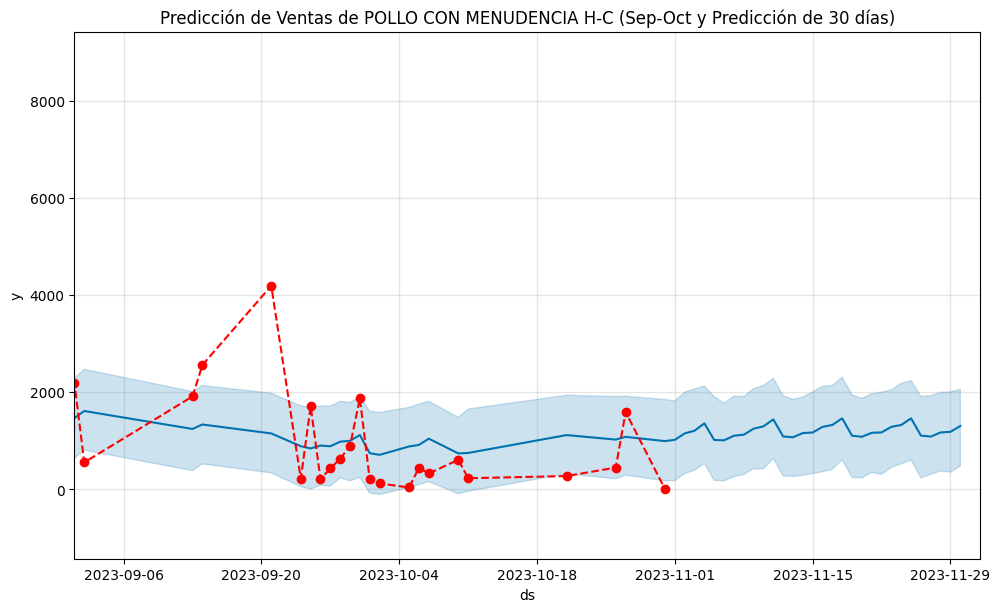

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/89dtnurd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jo4yu6f/_wrnaj62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35275', 'data', 'file=/tmp/tmp6jo4yu6f/89dtnurd.json', 'init=/tmp/tmp6jo4yu6f/_wrnaj62.json', 'output', 'file=/tmp/tmp6jo4yu6f/prophet_modellltmfvyk/prophet_model-20240222235801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:58:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para POLLO CON MENUDENCIA H-C:
            ds      yhat
820 2023-11-01 1017.2920
821 2023-11-02 1149.3965
822 2023-11-03 1204.6498
823 2023-11-04 1356.2281
824 2023-11-05 1013.8630
825 2023-11-06 1006.4489
826 2023-11-07 1101.4700
827 2023-11-08 1121.9553
828 2023-11-09 1246.9261
829 2023-11-10 1294.3561
830 2023-11-11 1437.5651
831 2023-11-12 1086.4451
832 2023-11-13 1070.0629
833 2023-11-14 1156.0838
834 2023-11-15 1167.7217
835 2023-11-16 1284.1826
836 2023-11-17 1323.6191
837 2023-11-18 1459.5197
838 2023-11-19 1101.9296
839 2023-11-20 1080.0492
840 2023-11-21 1161.6534
841 2023-11-22 1170.0382
842 2023-11-23 1284.4613
843 2023-11-24 1323.0941
844 2023-11-25 1459.4104
845 2023-11-26 1103.4059
846 2023-11-27 1084.1980
847 2023-11-28 1169.4463
848 2023-11-29 1182.3013
849 2023-11-30 1301.8493
             ds NombreProducto        y
0    2018-11-01    ALA PRIMERA   7.5440
1    2018-11-02    ALA PRIMERA  89.1480
2    2018-11-03    ALA PRIMERA  87.9520
3

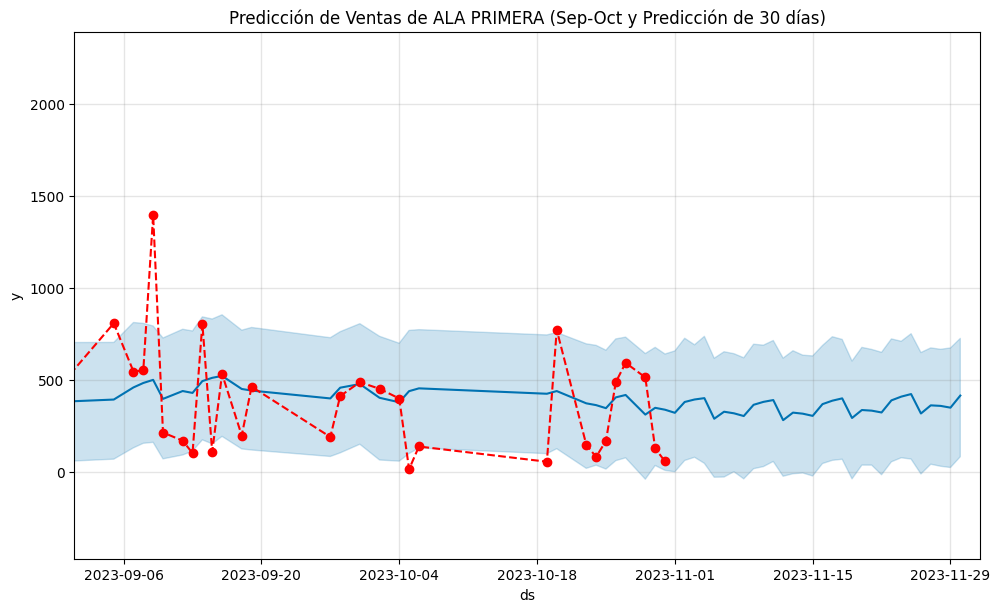

Predicción con todos los valores para ALA PRIMERA:
             ds     yhat
1004 2023-11-01 319.3566
1005 2023-11-02 378.2097
1006 2023-11-03 391.7498
1007 2023-11-04 399.0594
1008 2023-11-05 287.0121
1009 2023-11-06 325.2207
1010 2023-11-07 316.6323
1011 2023-11-08 301.8161
1012 2023-11-09 362.8727
1013 2023-11-10 378.8155
1014 2023-11-11 388.6923
1015 2023-11-12 279.3404
1016 2023-11-13 320.3356
1017 2023-11-14 314.5877
1018 2023-11-15 302.6295
1019 2023-11-16 366.5257
1020 2023-11-17 385.2558
1021 2023-11-18 397.8351
1022 2023-11-19 291.0704
1023 2023-11-20 334.5094
1024 2023-11-21 331.0359
1025 2023-11-22 321.1590
1026 2023-11-23 386.9218
1027 2023-11-24 407.2845
1028 2023-11-25 421.2453
1029 2023-11-26 315.5957
1030 2023-11-27 359.8703
1031 2023-11-28 356.9417
1032 2023-11-29 347.3096
1033 2023-11-30 413.0102


In [38]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'

# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='red', marker='o', linestyle='dashed')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [39]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Crear un nombre único para la columna de predicciones de Prophet
#     col_name = f'P-V_PROPHET_{product}'

#     # Convertir la columna de fecha a tipo datetime
#     product_df['FechaMovimiento'] = pd.to_datetime(product_df.index)

#     # Fusionar el DataFrame de ventas con el DataFrame de predicciones
#     product_df = pd.merge(product_df, valores_prediccion[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

#     # Renombrar la columna yhat a Ventas_PROPHET
#     product_df.rename(columns={'yhat': col_name}, inplace=True)

#     # Opcional: Eliminar la columna adicional 'ds' si no la necesitas
#     product_df.drop(columns=['ds'], inplace=True)

#     # Actualizar el DataFrame en el diccionario
#     dfs_noviembre_sumados[product] = product_df

In [40]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.

In [41]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
 FechaMovimiento                                        
 2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
 2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
 2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
 2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
 2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
 2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
 2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
 2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
 2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
 2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
 2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
 2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
 2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
 2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
 2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
 20

# LSTM


In [42]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [43]:
print(dfs_de_productos_sumados_lstm['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_lstm)

NombreProducto     object
MontoBase         float64
DayOW               int64
Month               int64
Year                int64
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  DayOW  Month  Year
FechaMovimiento                                                         
2018-11-03       POLLO SIN MENUDENCIA H-C   209.3280      5     11  2018
2018-11-04       POLLO SIN MENUDENCIA H-C   456.5700      6     11  2018
2018-11-05       POLLO SIN MENUDENCIA H-C   313.8140      0     11  2018
2018-11-06       POLLO SIN MENUDENCIA H-C   704.3460      1     11  2018
2018-11-07       POLLO SIN MENUDENCIA H-C   257.6550      2     11  2018
...                                   ...        ...    ...    ...   ...
2023-10-27       POLLO SIN MENUDENCIA H-C  5064.5984      4     10  2023
2023-10-28       POLLO SIN MENUDENCIA H-C   987.0990      5     10  2023
2023-10-29       POLLO SIN MENUDENCIA H-C  2787.4978      6     10  2023
2023-10-30       POLLO S

In [44]:
# Función para crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])


In [45]:
# #Otro enfoque creando anteriormente las fechas de noviembre para las predicciones
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         seq = data[i : i + seq_length]
#         label = data[i + seq_length]
#         X.append(seq)
#         y.append(label)
#     return np.array(X), np.array(y)

## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

In [46]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    product_df_lstm['MontoBase_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    X, y = create_sequences(product_df_lstm['MontoBase_scaler'].values, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Visualizar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(product_df_lstm.index[train_size+seq_length:], product_df_lstm['MontoBase'].values[train_size+seq_length:], label='Real - ' + product)
    plt.plot(product_df_lstm.index[train_size+seq_length:], predictions, label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_data = product_df_lstm[product_df_lstm.index >= '2023-09-01']['MontoBase'].values


    print("Dimensiones de fechas:", product_df_lstm.index[train_size+seq_length-1:].shape)
    print("Dimensiones de predicciones:", predictions.shape)

    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')

    # Verificar si hay datos disponibles después de '2023-09-01'
    if len(last_data) >= seq_length:
        last_data = scaler.transform(last_data.reshape(-1, 1))
        input_data, _ = create_sequences(last_data, seq_length)

        # Imprimir la forma de input_data para depuración
        print("Forma de input_data:", input_data.shape)

        # Verificar si input_data está vacío antes del reshape
        if input_data.shape[0] == 0:
            print("¡Error! input_data está vacío.")
        else:
            # Reshape para el modelo LSTM
            input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
            # Imprimir la forma después del reshape para depuración
            print("Forma de input_data después del reshape:", input_data.shape)

        # Hacer predicciones para el futuro
        predictions_future = model.predict(input_data)
        #predictions_future_nov = model.predict(last_data)

#df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

        # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
        fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
        predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
        predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
        predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
        predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

        # Imprimir el DataFrame inicial para depuración
        print(predicciones_df_lstm)

        # Desnormalizar las predicciones
        predictions_future = scaler.inverse_transform(predictions_future)

        # Actualizar las predicciones reales en las fechas correspondientes
        predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

        # Imprimir el DataFrame actualizado para depuración
        print(predicciones_df_lstm)

        # Agregar la columna al DataFrame original
        dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

        # Visualizar los resultados
        plt.figure(figsize=(15, 7))
        # Datos de venta desde el 1ro de septiembre de 2023
        start_date = '2023-09-01'
        end_date = '2023-11-30'
        plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
        plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product)
        # Datos reales de noviembre
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title('Ventas y Predicciones - ' + product)
        plt.xlabel('Fecha')
        plt.ylabel('MontoBase')
        plt.legend()
        plt.show()
    else:
        print("No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.")
        # # Almacenar las predicciones en el objeto principal
        # dfs_noviembre_sumados[product] = pd.merge(dfs_noviembre_sumados[product], predictions_df_lstm, on='FechaMovimiento', how='left')

Output hidden; open in https://colab.research.google.com to view.

In [47]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA

## Evaluar LSTM




In [48]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 3864491.1298343493
MAE is : 1657.604093242188
R2 is : -0.3402034571434893 %
------------------------------
RMSE is : 1965.8309006204856
MAPE is : 101.79946838057606 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 39995.97496939632
MAE is : 162.60987125
R2 is : -0.11518147402141232 %
------------------------------
RMSE is : 199.98993717033943
MAPE is : 45.87902151192454 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 124774.27093852228
MAE is : 245.2497931705729
R2 is : -0.8307242677395754 %
------------------------------
RMSE is : 

# ARIMA

In [49]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [51]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [52]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1373 entries, 2018-11-03 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1373 non-null   object 
 1   MontoBase       1373 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.2+ KB


In [ ]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    if len(product_df_arima) >= 365:
        # Aquí puedes poner el código para realizar la predicción con ARIMA
        print(f"Predicciones para {product}:")
        # Realizar descomposición estacional
        decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        decomposition.plot();
        plt.show()

        # Visualizar ACF y PACF
        plt.style.use('dark_background')
        plot_acf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        plot_pacf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        # Dividir en orden cronológico, entrenando sin el mes de octubre
        train_size_arima = int(len(product_df_arima) - 31)
        train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

        print(train_arima.shape, test_arima.shape)

        # Identificar el modelo ARIMA automáticamente
        modelo_auto = auto_arima(train_arima['MontoBase'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
        print(modelo_auto.summary())

        # Configurar el modelo ARIMA
        arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
        arima_result = arima_model.fit()
        arima_models[product] = arima_result  # Guardar el modelo en el diccionario

        # Hacer predicciones con ARIMA
        arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
        # Crear un índice para las predicciones de noviembre
        november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
        arima_pred.index = november_index

        print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
        print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

        # Imprimir las predicciones para el mes de noviembre
        print(arima_pred)

        # Agregar las predicciones al DataFrame original
        if product in arima_models:
            # Hacer predicciones con ARIMA para el DataFrame actual
            arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

            # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
            arima_pred_full.index = dfs_noviembre_sumados[product].index

            # Agregar la columna de predicciones ARIMA al DataFrame actual
            dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

            # Imprimir el resultado
            print(f'\nVentas reales y predicciones ARIMA para {product}:')
            print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
        else:
            print(f"No hay modelo ARIMA para {product}.")

        # Visualizar las predicciones y los datos reales
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (20, 8)
        # Datos de venta desde el 1ro de septiembre de 2023
        start_date = '2023-09-01'
        end_date = '2023-11-30'
        plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
        plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
        plt.xlabel('Meses')
        plt.ylabel('')
        plt.legend(fontsize=16)
        plt.show()
    else:
        print(f"No hay suficientes datos para hacer una predicción con ARIMA para {product}.")

Output hidden; open in https://colab.research.google.com to view.

In [61]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.

In [62]:
# ESTO ES PARA ELIMINAR LA COLUMA DE PREDICCION DE ARIMA QUE aparecia con 'nan'
# for product, product_df in dfs_noviembre_sumados.items():
#     product_df.drop(columns=[f'P-V_ARIMA_{product}'], inplace=True)
#     print(product_df)


## Evaluar ARIMA

In [63]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 5672574.775076112
MAE is : 1981.0086443274197
R2 is : -0.9672458983720924 %
------------------------------
RMSE is : 2381.716770540971
MAPE is : 121.68348014686497 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 79823.91256769365
MAE is : 242.2157934789152
R2 is : -1.2256776725035676 %
------------------------------
RMSE is : 282.53125945228373
MAPE is : 56.23752321457094 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 133074.47612676112
MAE is : 306.15937305699816
R2 is : -0.9525072839898865 %
------------------------------
RMSE i

Cómo interpretar las gráficas de residuos en el modelo ARIMA


# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-64-18dcb7d60c8b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


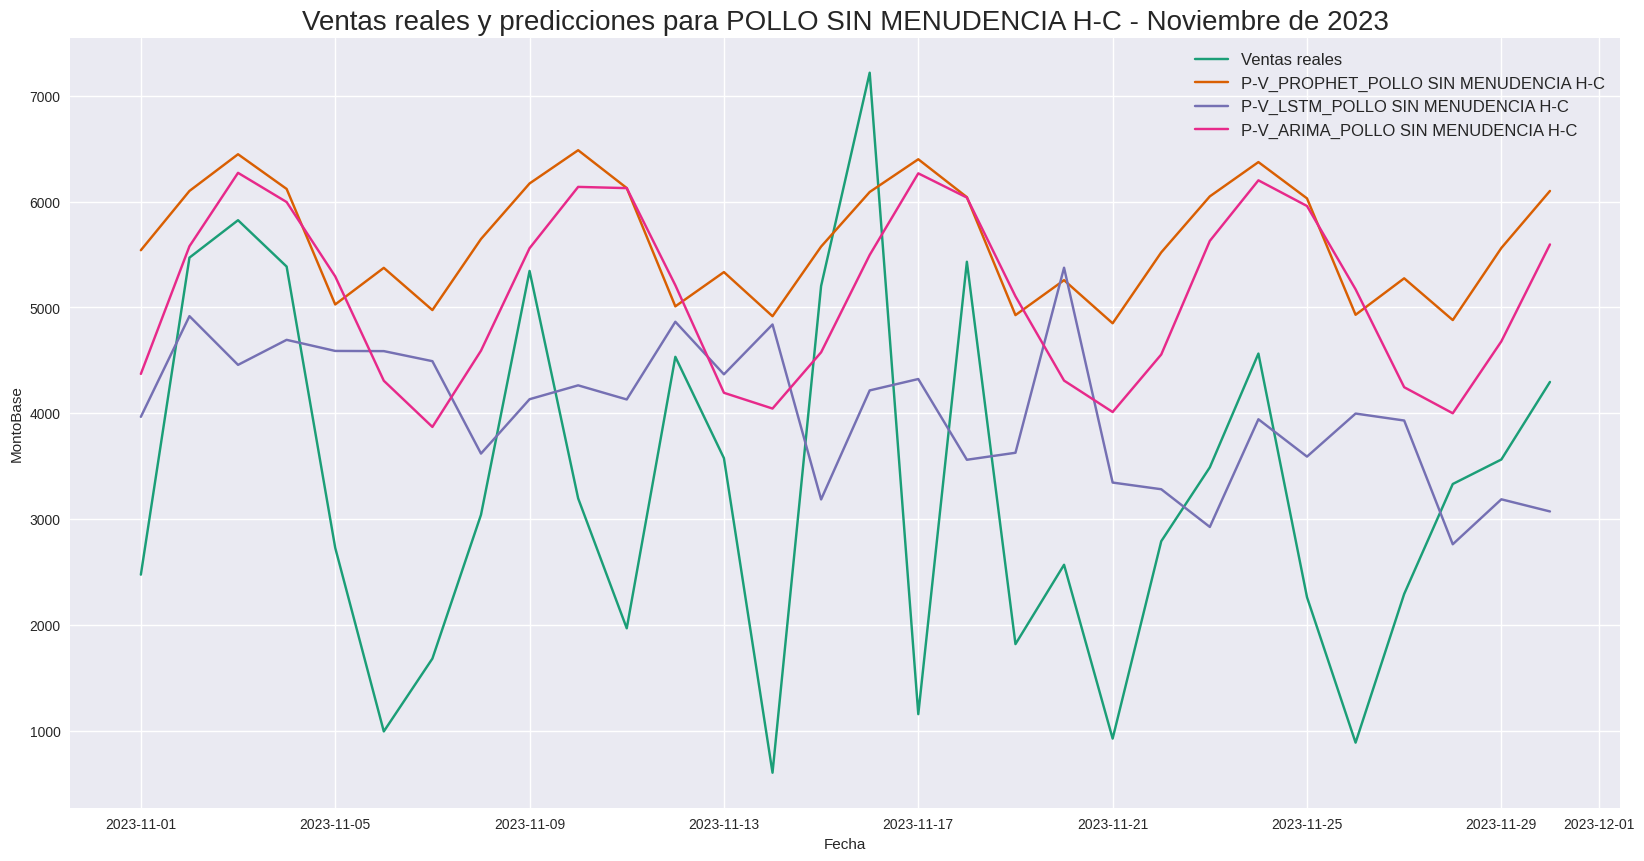

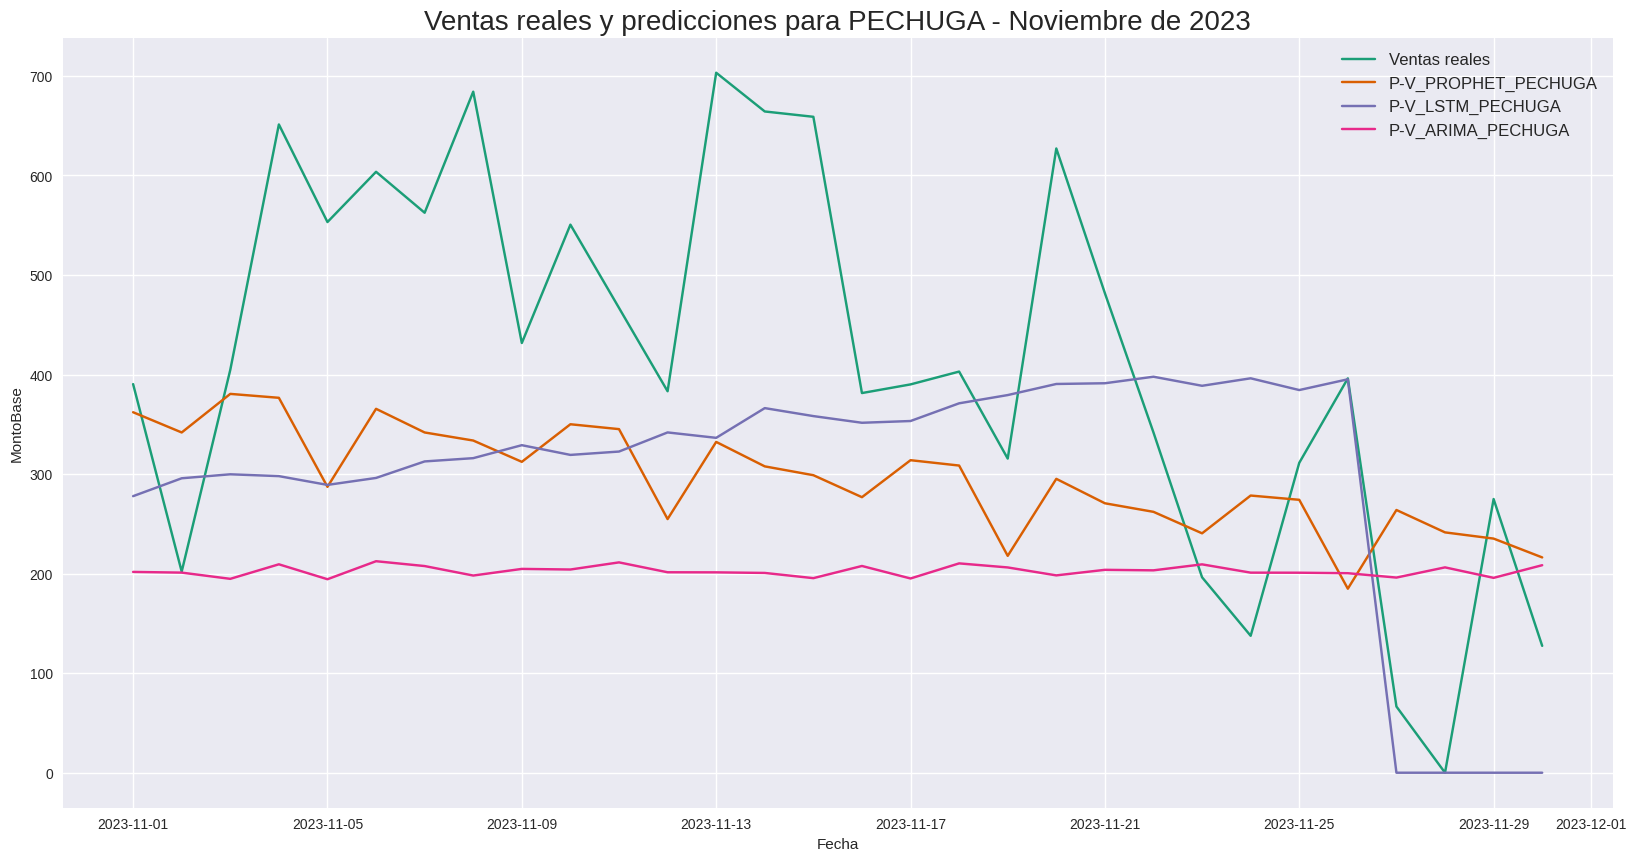

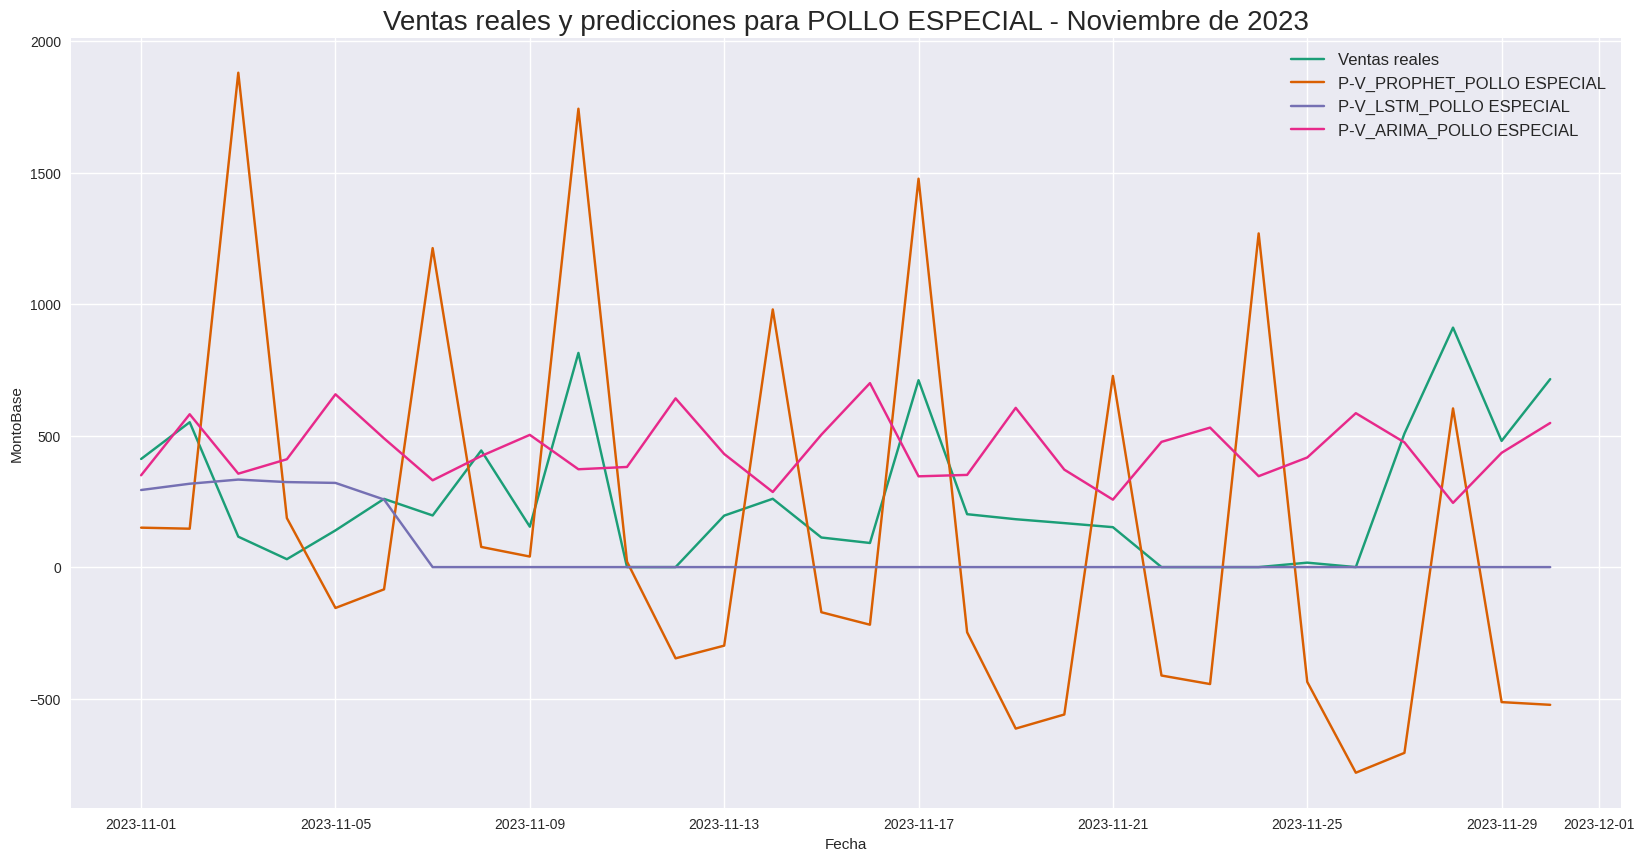

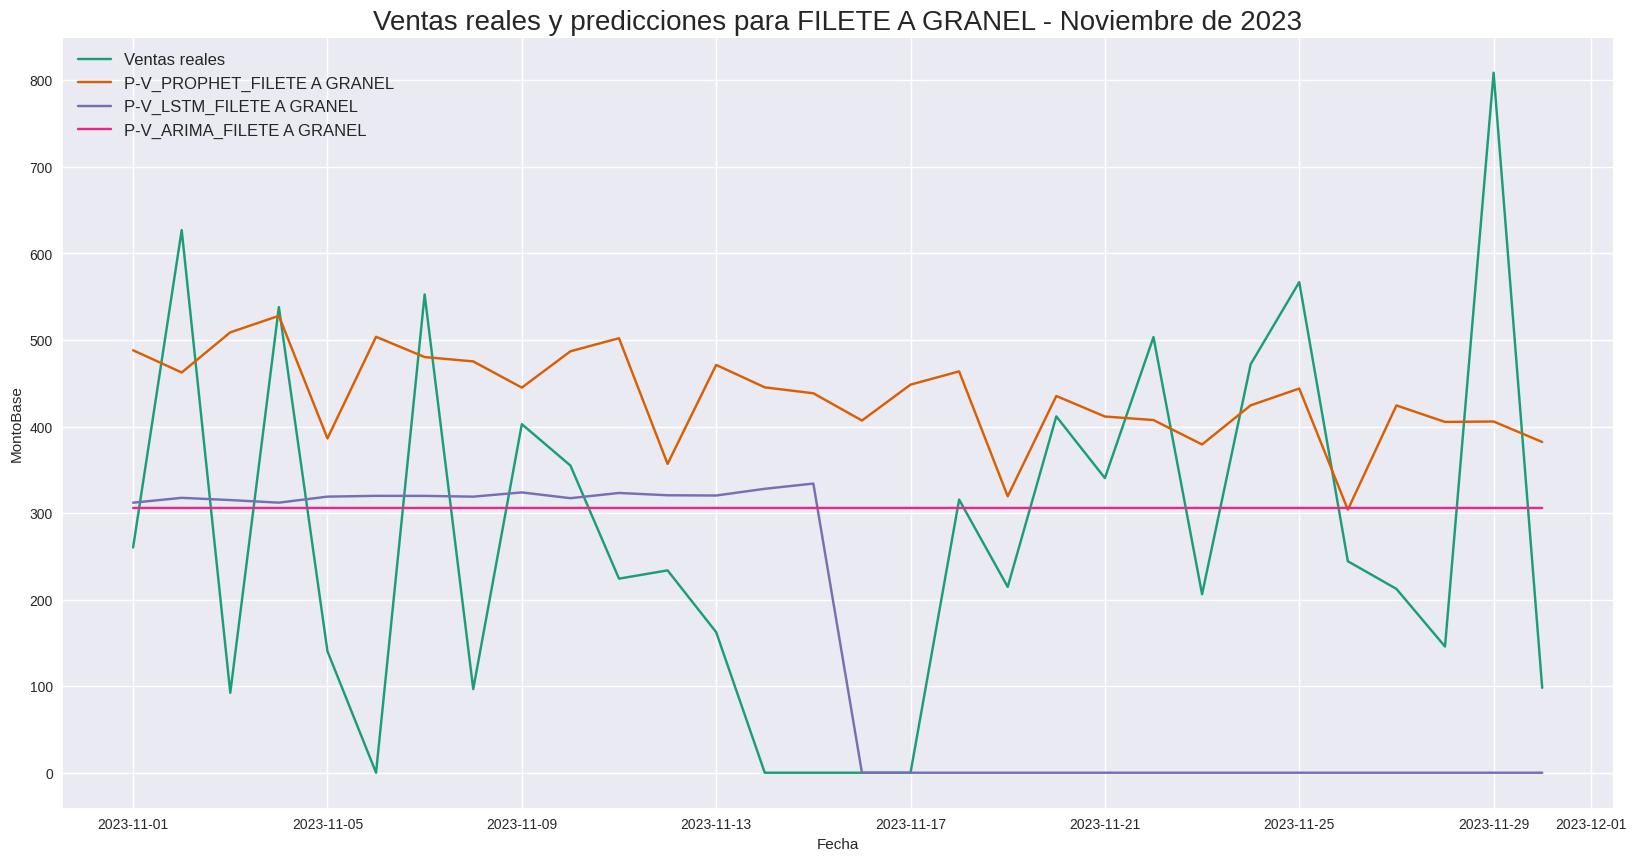

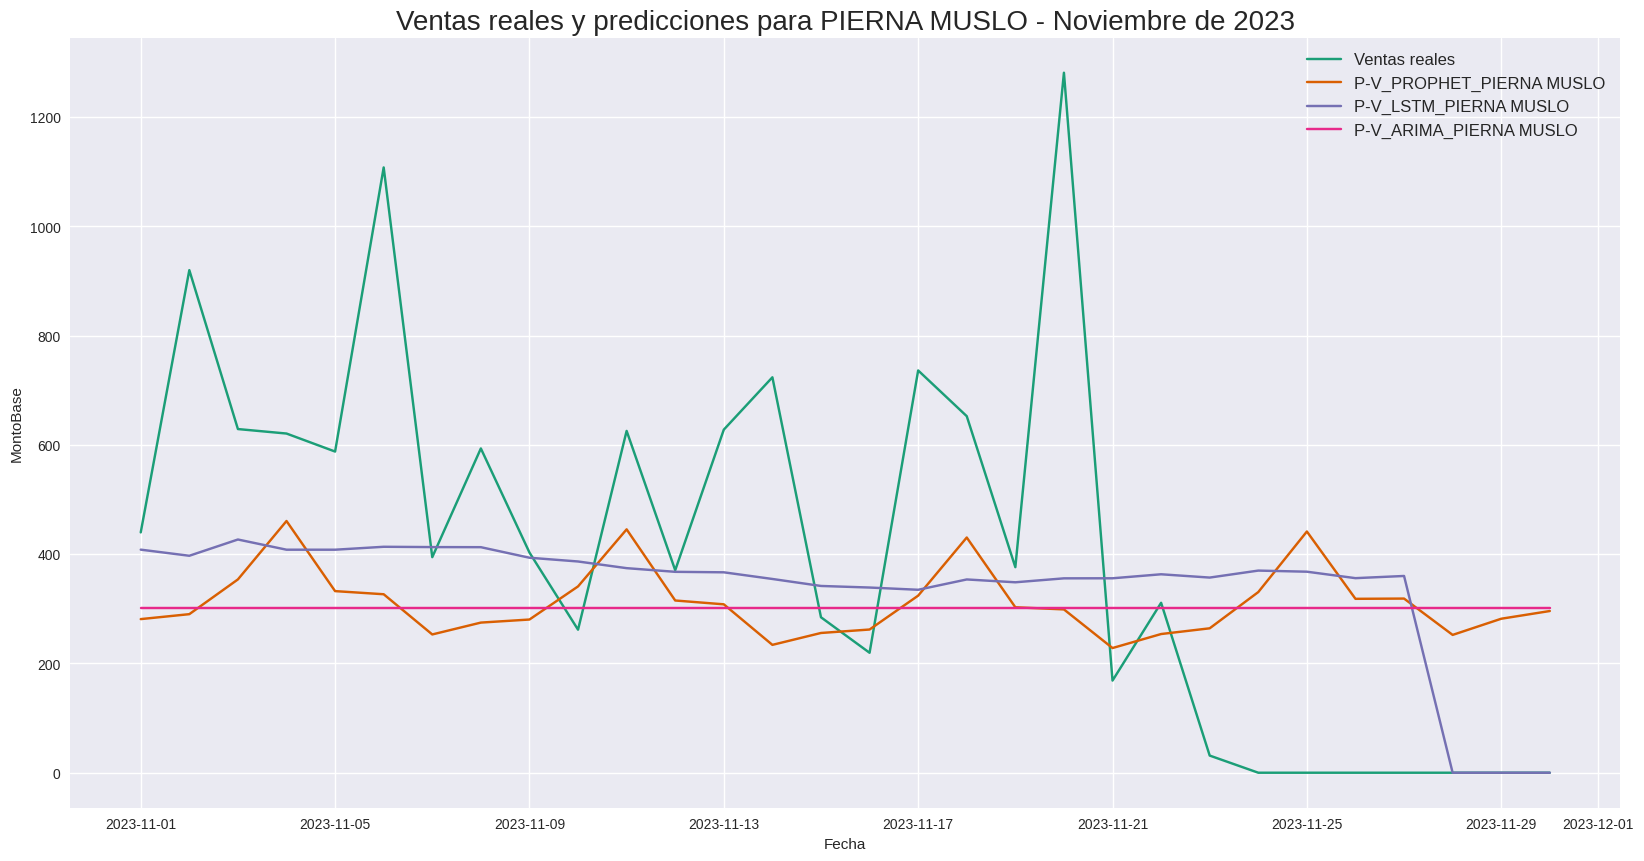

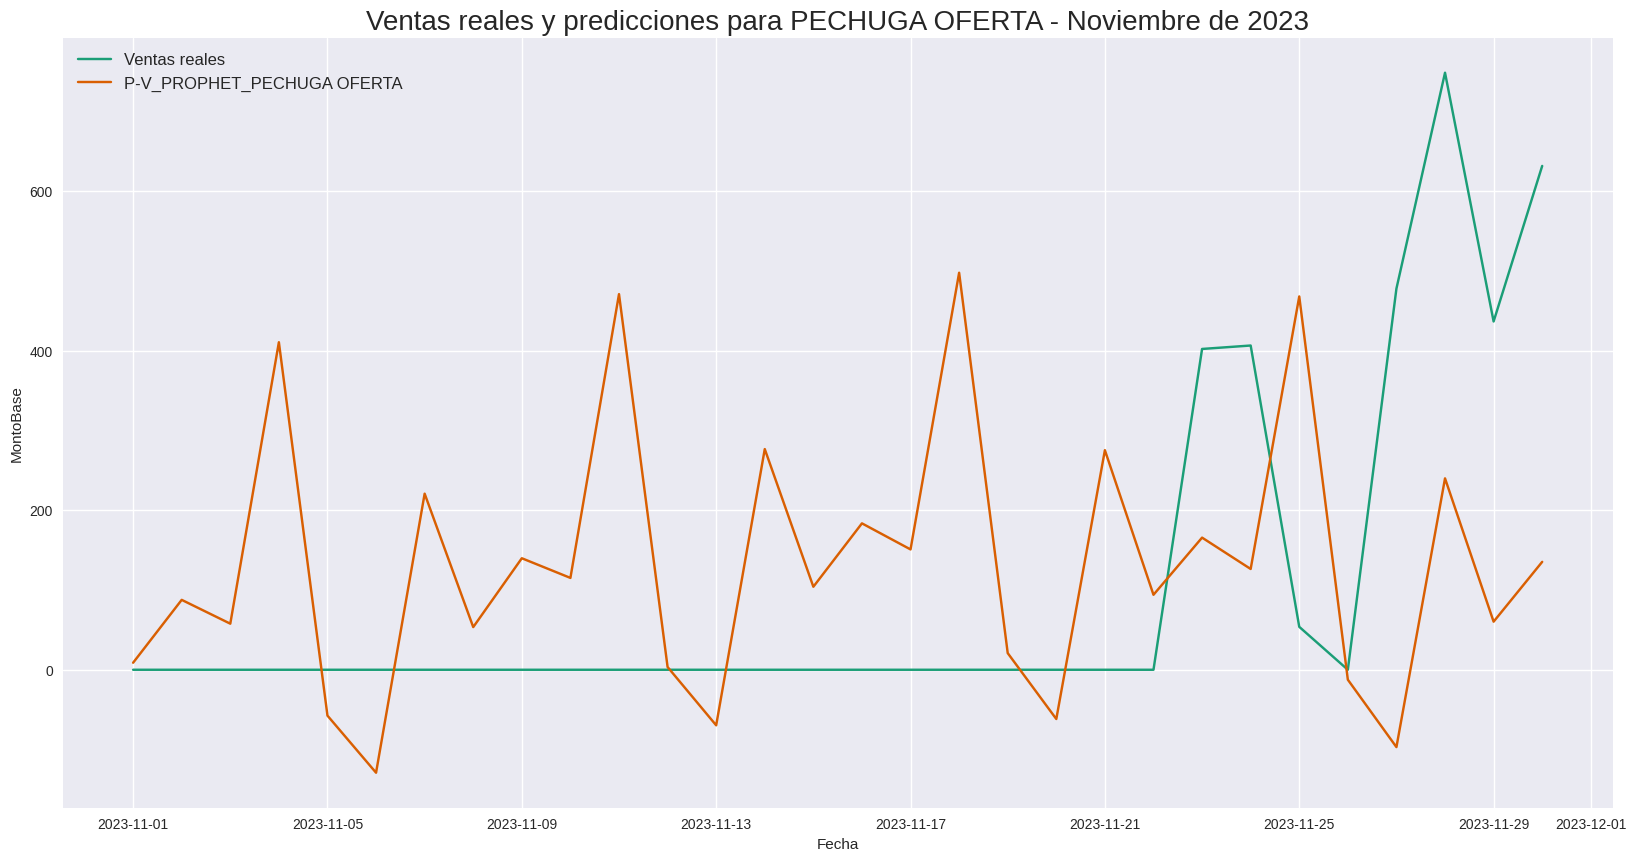

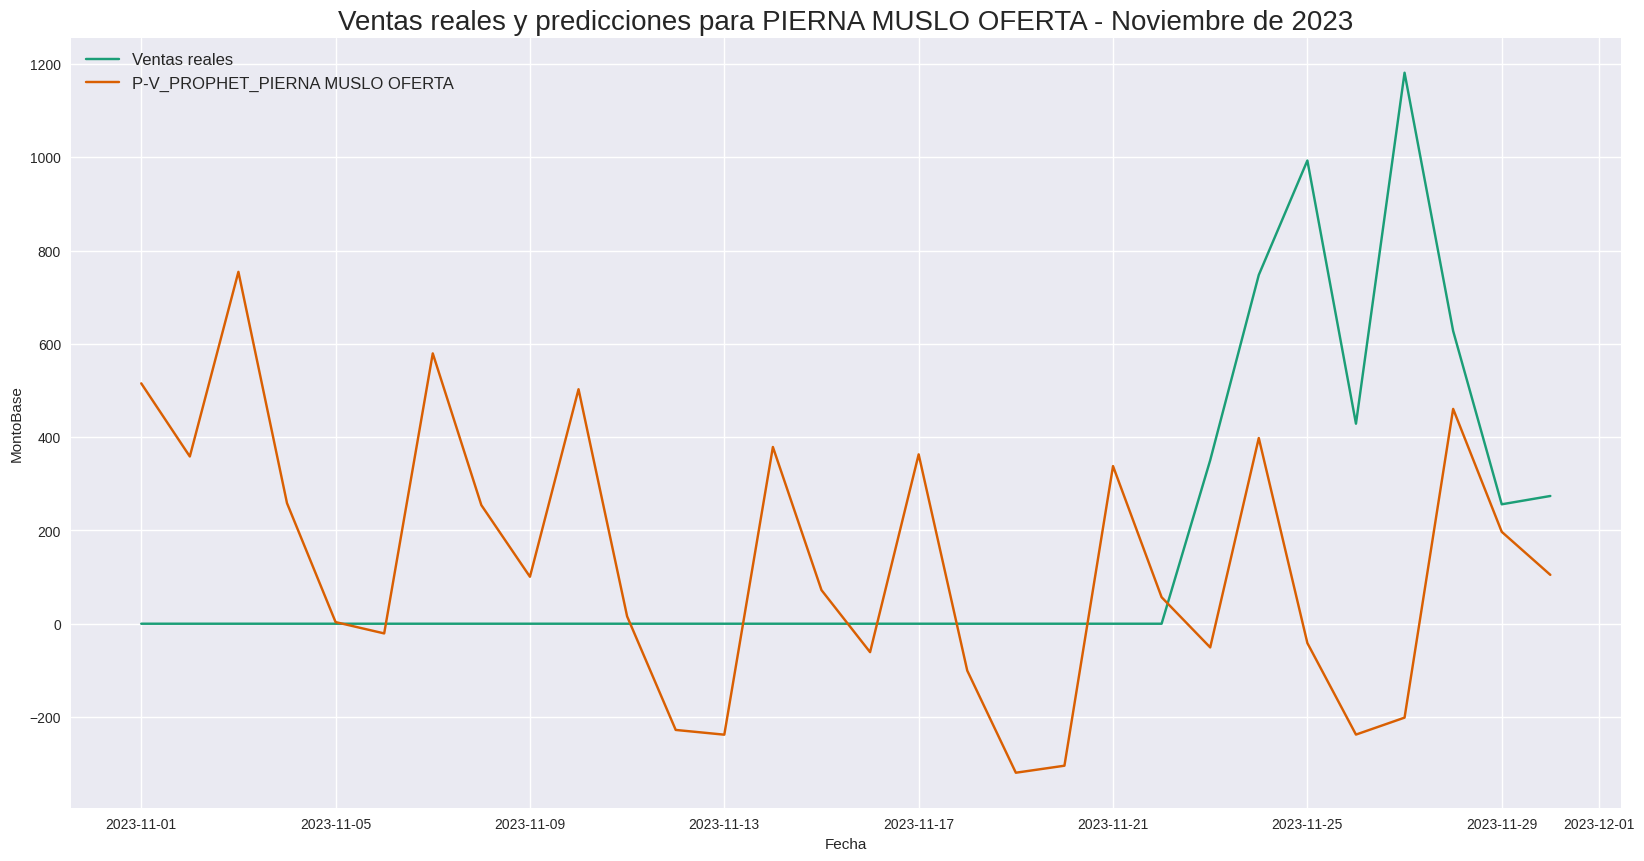

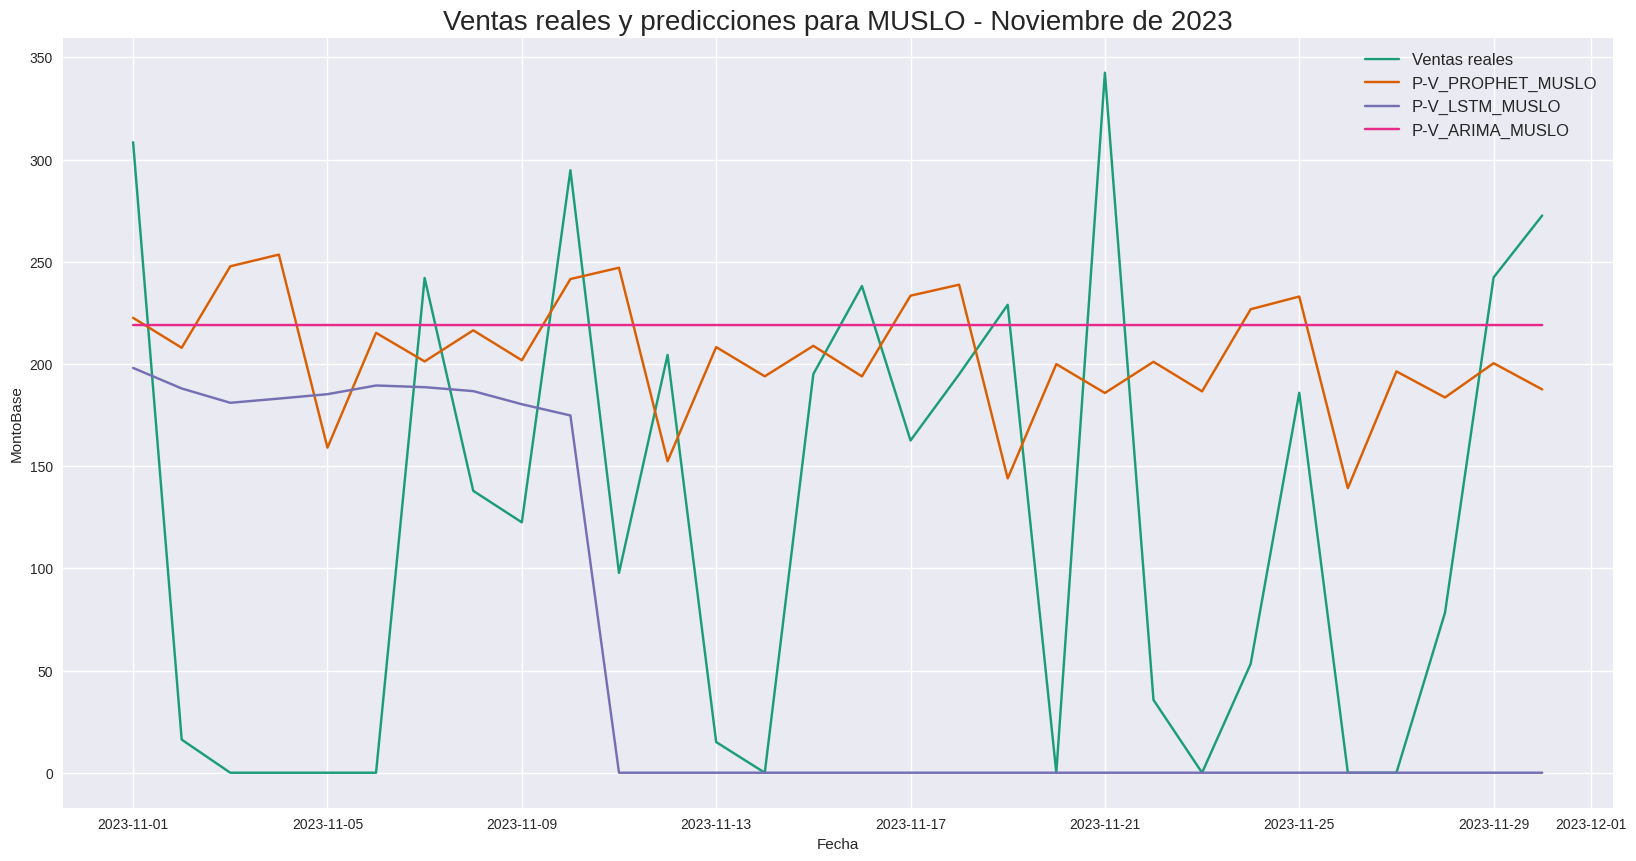

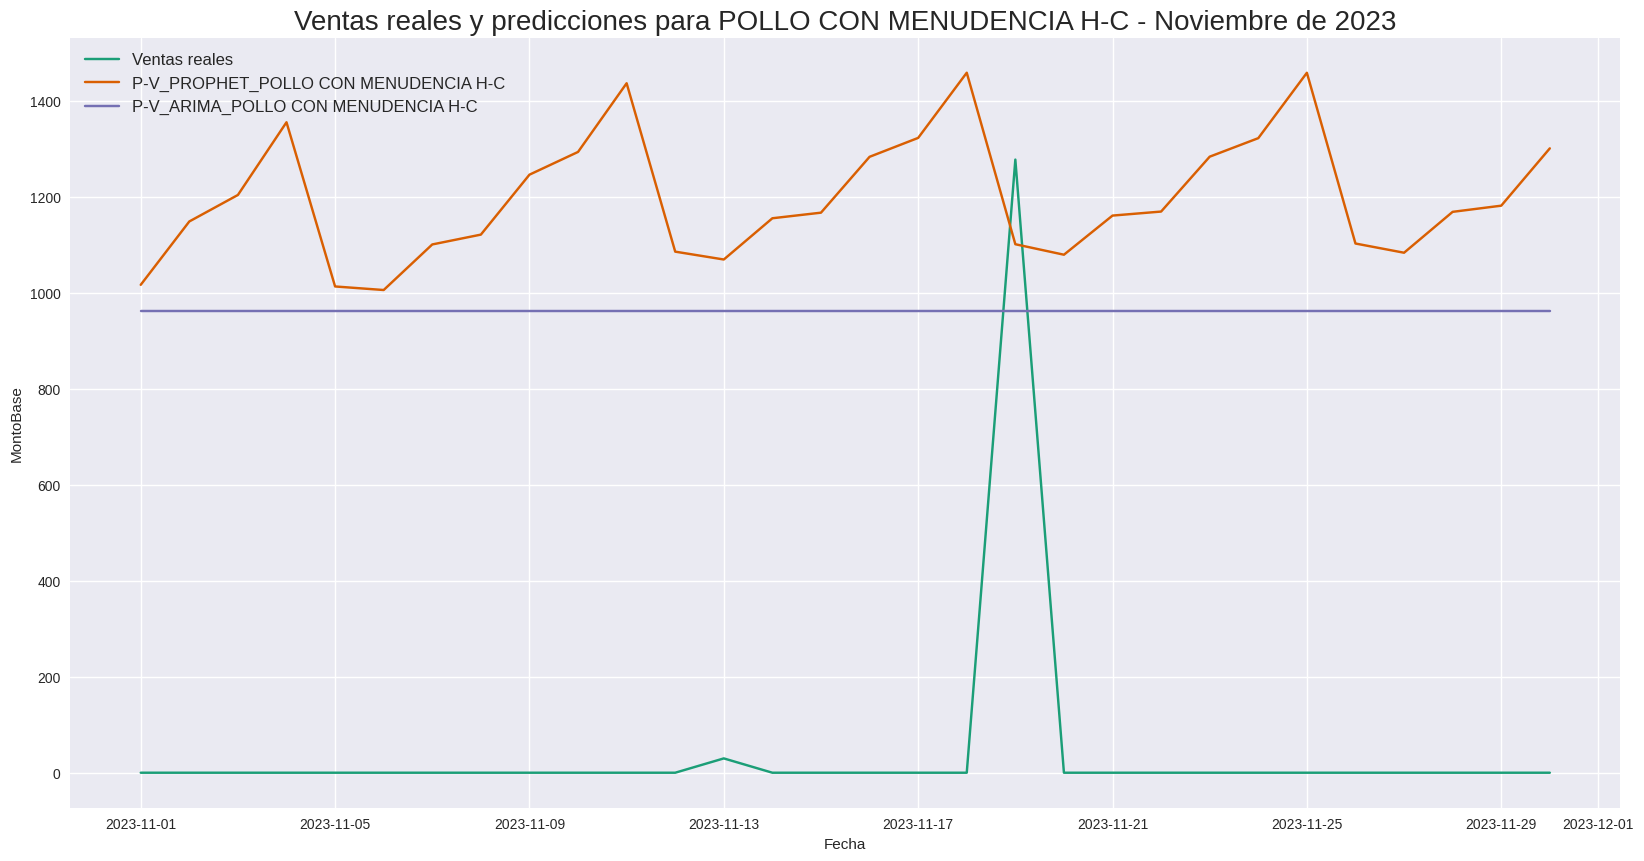

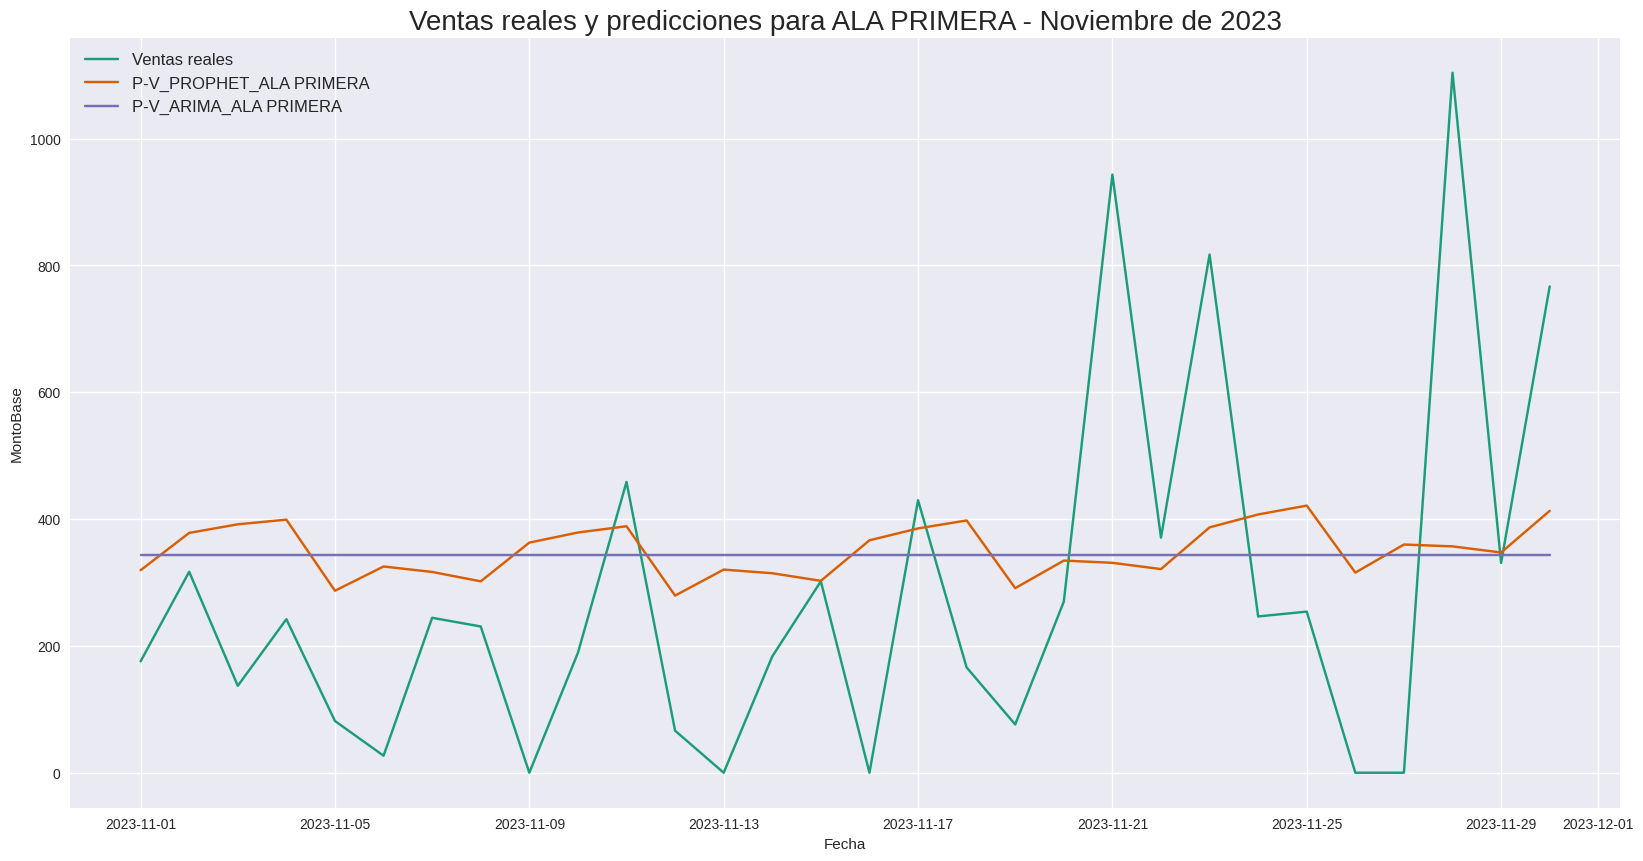

In [64]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales')

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [65]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO SIN MENUDENCIA H-C
Modelo: PROPHET
Evaluation metric results:  
MSE is : 7707179.992817389
MAE is : 2424.354426497942
R2 is : -1.6728458998025326 %
------------------------------
RMSE is : 2776.1808285515895
MAPE is : 145.12629815463848 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 3864491.1298343493
MAE is : 1657.604093242188
R2 is : -0.3402034571434893 %
------------------------------
RMSE is : 1965.8309006204856
MAPE is : 101.79946838057606 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 5672574.775076112
MAE is : 1981.0086443274197
R2 is : -0.9672458983720924 %
------------------------------
RMSE is : 2381.716770540971
MAPE is : 1

In [66]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
 FechaMovimiento                                        
 2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
 2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
 2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
 2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
 2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
 2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
 2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
 2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
 2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
 2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
 2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
 2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
 2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
 2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
 2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
 20

In [71]:
for product, product_df in dfs_de_productos_sumados.items():
    print(f"Información para {product}:")
    print(product_df.info())


Información para POLLO SIN MENUDENCIA H-C:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1373 entries, 2018-11-03 to 2023-10-31
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1373 non-null   object 
 1   year            1373 non-null   int64  
 2   MontoBase       1373 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 42.9+ KB
None
Información para PECHUGA:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2018-11-05 to 2023-10-31
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1166 non-null   object 
 1   year            1166 non-null   int64  
 2   MontoBase       1166 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 36.4+ KB
None
Información para POLLO ESPECIAL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1249 entrie